<center> <h1> content-based recommendation  </h1> <center>




### 1 Overview of the data

In [1]:
#import all the necessary packages.

from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
import math
import time
import re
import os
import seaborn as sns
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
import sklearn.metrics as metrics
from sklearn.metrics.pairwise import cosine_similarity  
from sklearn.metrics import pairwise_distances
from matplotlib import gridspec
from scipy.sparse import hstack
import plotly
import plotly.figure_factory as ff
from plotly.graph_objs import Scatter, Layout
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_absolute_error, mean_squared_error

plotly.offline.init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")

In [2]:

from google.colab import drive
drive.mount("/content/drive")

os.chdir('drive/My Drive/Colab Notebooks')
!pwd

Mounted at /content/drive
/content/drive/My Drive/Colab Notebooks


# 2 Text based product similarity

In [ ]:
data = pd.read_pickle('pickles/clothing_info_preprocessed')
data = data.reset_index(drop=True)
data.head()

asin  ...                                    large_image_url
0  B004GSI2OS  ...  https://images-na.ssl-images-amazon.com/images...
1  B012YX2ZPI  ...  https://images-na.ssl-images-amazon.com/images...
2  B003BSRPB0  ...  https://images-na.ssl-images-amazon.com/images...
3  B014ICEJ1Q  ...  https://images-na.ssl-images-amazon.com/images...
4  B01NACPBG2  ...  https://images-na.ssl-images-amazon.com/images...

[5 rows x 7 columns]

In [ ]:
data.shape

(16319, 7)

In [ ]:
data['title'].nunique()

16318

In [ ]:
# Định nghĩa sẵn các hàm để sử dụng 


#Hiển thị image
def display_img(url,ax,fig):
    # i get the url of the apparel and download it
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    # i will display it in notebook 
    plt.imshow(img)
  
#plotting code 
def plot_heatmap(keys, values, labels, url, text):
        # keys: danh sách các từ của tiêu đề được đề xuất
        # values: len(values) ==  len(keys), values(i) đại diện cho sự xuất hiện của key từ (i)
        # labels: len(labels) == len(keys), giá trị của các nhãn phụ thuộc vào kiểu máy chúng ta đang sử dụng
                # if model == 'bag of words': labels(i) = values(i)
                # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
                # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))
        # url : item's url

        # chúng tôi sẽ chia toàn bộ con số thành hai phần
        gs = gridspec.GridSpec(2, 2, width_ratios=[4,1], height_ratios=[4,1], wspace=.01) 
        fig = plt.figure(figsize=(25,3))
        
        # 1st, ploting heat map that represents the count of commonly ocurred words in title2
        ax = plt.subplot(gs[0])
        # nó sẽ hiển thị một ô màu trắng nếu từ đó là giao nhau (các từ của tiêu đề1 và danh sách các từ của tiêu đề2), màu đen nếu không
        ax = sns.heatmap(np.array([values]), annot=np.array([labels]))
        ax.set_xticklabels(keys) # set that axis labels as the words of title
        ax.set_title(text) # apparel title
        
        # 2nd, ploting hình ảnh của sản phẩm
        ax = plt.subplot(gs[1])
        # tôi không muốn có bất kỳ grid line nào cho hình ảnh và không có nhãn trên trục x và trục y
        ax.grid(False)
        ax.set_xticks([])
        ax.set_yticks([])
        
        # chúng tôi gọi dispaly_img dựa trên tham số url
        display_img(url, ax, fig)
        
        # màn hình kết hợp hình (bản đồ heatmap và hình ảnh với nhau)
        plt.show()
    
def plot_heatmap_image(doc_id, vec1, vec2, url, text, model):

    # doc_id : stt của title1
    # vec1 :  vector sản phẩm đầu vào, có dạng dict {word:count}
    # vec2 : vectoc sản phẩm gợi ý, có dạng dict {word:count}
    # url :  image url của sản phẩm
    # text: title của sản phẩm gợi ý (used to keep title of image)
    # model, một trong ba dạng ta sẽ nghiên cứu, 
        # 1. bag_of_words
        # 2. tfidf
        # 3. idf

    # chúng tôi tìm thấy những từ chung trong cả hai tiêu đề, bởi vì những từ duy nhất này góp phần tạo ra khoảng cách giữa hai tiêu đề vec's
    intersection = set(vec1.keys()) & set(vec2.keys()) 

    # chúng tôi đặt giá trị của các từ không giao nhau thành 0, điều này chỉ để hiển thị sự khác biệt trong bản đồ heatmap
    for i in vec2:
        if i not in intersection:
            vec2[i]=0

    # để gắn nhãn bản đồ heatmap, các key chứa danh sách tất cả các từ trong title2
    keys = list(vec2.keys())
    #  if ith word in intersection(lis of words of title1 and list of words of title2): values(i)=count of that word in title2 else values(i)=0 
    values = [vec2[x] for x in vec2.keys()]
    
    # labels: len(labels) == len(keys), giá trị của các labels phụ thuộc vào kiểu model chúng ta đang sử dụng
        # if model == 'bag of words': labels(i) = values(i)
        # if model == 'tfidf weighted bag of words':labels(i) = tfidf(keys(i))
        # if model == 'idf weighted bag of words':labels(i) = idf(keys(i))

    if model == 'bag_of_words':
        labels = values
    elif model == 'tfidf':
        labels = []
        for x in vec2.keys():
            # tfidf_title_vectorizer.vocabulary_ it chứa tất cả các từ trong kho ngữ liệu
            # tfidf_title_features[doc_id, index_of_word_in_corpus] sẽ cung cấp giá trị tfidf của từ trong tài liệu nhất địnht (doc_id)
            if x in  tfidf_title_vectorizer.vocabulary_:
                labels.append(tfidf_title_features[doc_id, tfidf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)
    elif model == 'idf':
        labels = []
        for x in vec2.keys():
            # idf_title_vectorizer.vocabulary_ it chứa tất cả các từ trong kho ngữ liệu
            # idf_title_features[doc_id, index_of_word_in_corpus] sẽ cung cấp giá trị idf của từ trong tài liệu nhất định (doc_id)
            if x in  idf_title_vectorizer.vocabulary_:
                labels.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[x]])
            else:
                labels.append(0)

    plot_heatmap(keys, values, labels, url, text)


# hàm này nhận danh sách các từ cùng với tần suất của mỗi từ 
def text_to_vector(text):
    word = re.compile(r'\w+')
    words = word.findall(text)
    # words lưu trữ danh sách tất cả các từ trong chuỗi đã cho, bạn có thể thử 'words = text.split ()', điều này cũng sẽ cho kết quả tương tự
    return Counter(words) # Bộ đếm thời gian xuất hiện của mỗi từ trong danh sách, nó trả về đối tượng kiểu dict {word1:count}



def get_result(doc_id, content_a, content_b, url, model):
    text1 = content_a
    text2 = content_b
    
    # vector1 = dict{word11:#count, word12:#count, etc.}
    vector1 = text_to_vector(text1)

    # vector1 = dict{word21:#count, word22:#count, etc.}
    vector2 = text_to_vector(text2)

    plot_heatmap_image(doc_id, vector1, vector2, url, text2, model)

## 2.1 Bag of Words (BoW) on product titles.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
title_vectorizer = CountVectorizer()
title_features   = title_vectorizer.fit_transform(data['title'])
title_features.get_shape() 



(16319, 12570)

In [ ]:
import nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def find_doc_id(text):
  
  string = ""
  for words in text.split():
      # remove the special chars in review like '"#$@!%^&*()_+-~?>< etc.
      word = ("".join(e for e in words if e.isalnum()))
      # Conver all letters to lower-case
      word = word.lower()
      # stop-word removal
      if not word in stop_words:
          string += word + " "

  doc_id = -1
  for i in range(data['title'].shape[0]):
    if data['title'].iloc[i] == string :
      doc_id = i
  return doc_id
    
find_doc_id('''Featherlite Ladies' Long Sleeve Stain Resistant Tapered Twill Shirt, 2XL, Onyx Black/ Stone''')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0

In [ ]:
data['title']

0        featherlite ladies long sleeve stain resistant...
1        womens unique 100 cotton  special olympics wor...
2        featherlite ladies moisture free mesh sport sh...
3        supernatural chibis sam dean castiel neck tshi...
4        fifth degree womens gold foil graphic tees jun...
                               ...                        
16314    yuelian womens chiffon short sleeves sun prote...
16315    vintage america womens large lace collared blo...
16316       tart womens collections ann wrap top xs black 
16317    soprano womens small tiefringe slubknit tank t...
16318    faded glory womens plaid button 2 pocket shirt...
Name: title, Length: 16319, dtype: object

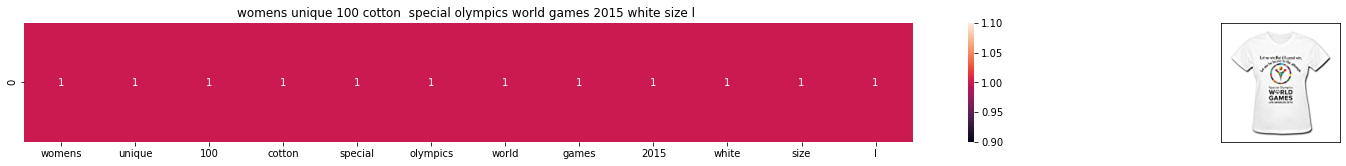

ASIN : B012YX2ZPI
Brand: HX-Kingdom Fashion T-shirts
Title: womens unique 100 cotton  special olympics world games 2015 white size l 
Cosine similarity with the query image : 0.0


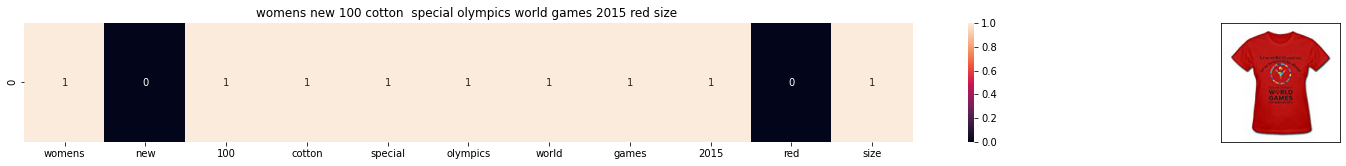

ASIN : B012YX3I5E
Brand: HX-Kingdom Fashion T-shirts
Title: womens new 100 cotton  special olympics world games 2015 red size 
Cosine similarity with the query image : 0.18181818181818166


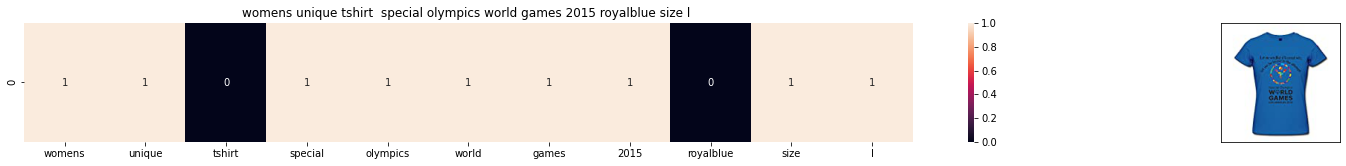

ASIN : B012YX4TVG
Brand: HX-Kingdom Fashion T-shirts
Title: womens unique tshirt  special olympics world games 2015 royalblue size l 
Cosine similarity with the query image : 0.23722992860352599


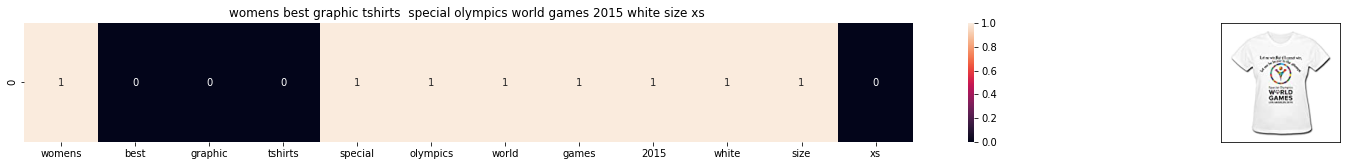

ASIN : B012YX2M3I
Brand: HX-Kingdom Fashion T-shirts
Title: womens best graphic tshirts  special olympics world games 2015 white size xs 
Cosine similarity with the query image : 0.3036893761772087


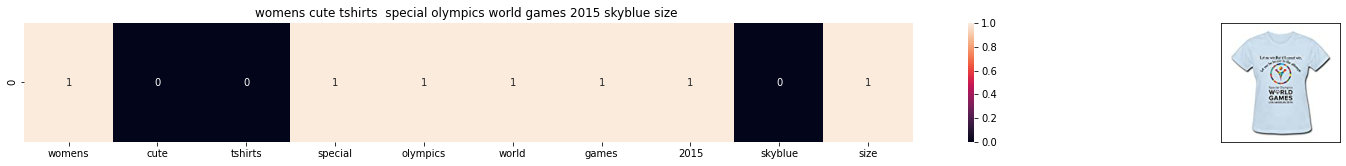

ASIN : B012YX30T8
Brand: HX-Kingdom Fashion T-shirts
Title: womens cute tshirts  special olympics world games 2015 skyblue size 
Cosine similarity with the query image : 0.33257618752808527


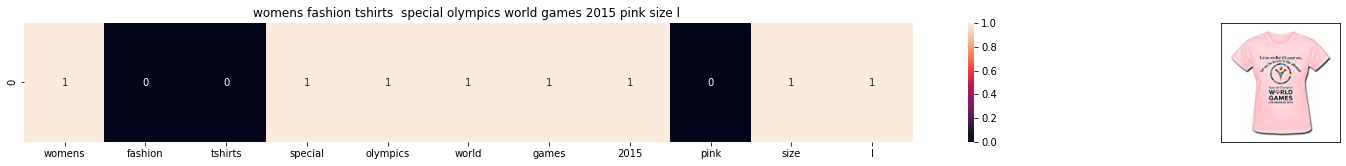

ASIN : B012YX26Q6
Brand: HX-Kingdom Fashion T-shirts
Title: womens fashion tshirts  special olympics world games 2015 pink size l 
Cosine similarity with the query image : 0.33257618752808527


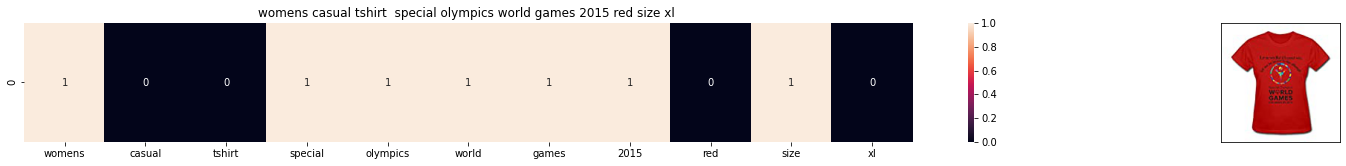

ASIN : B012YX3XTU
Brand: HX-Kingdom Fashion T-shirts
Title: womens casual tshirt  special olympics world games 2015 red size xl 
Cosine similarity with the query image : 0.36363636363636354


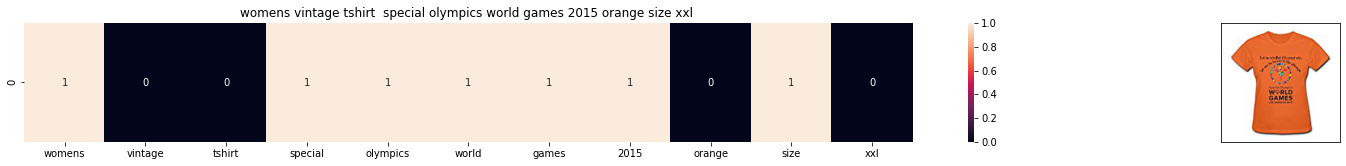

ASIN : B012YX4LVE
Brand: HX-Kingdom Fashion T-shirts
Title: womens vintage tshirt  special olympics world games 2015 orange size xxl 
Cosine similarity with the query image : 0.36363636363636354


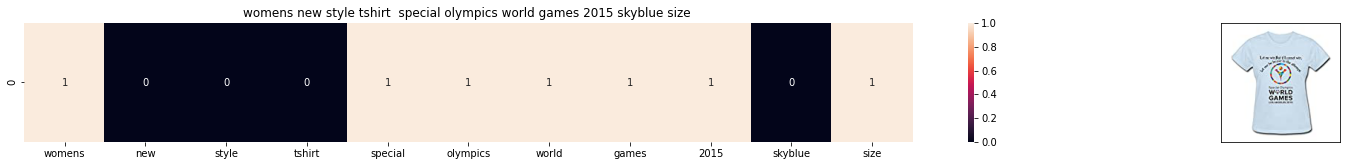

ASIN : B012YX2OJU
Brand: HX-Kingdom Fashion T-shirts
Title: womens new style tshirt  special olympics world games 2015 skyblue size 
Cosine similarity with the query image : 0.36363636363636354


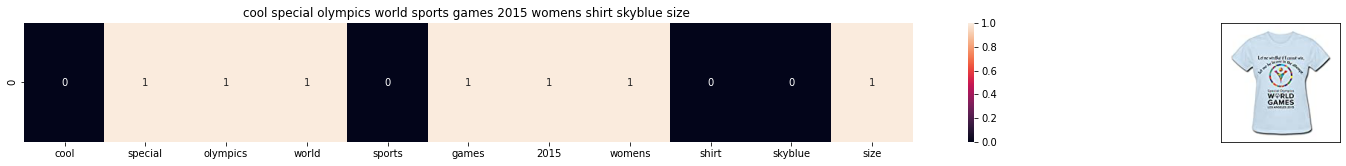

ASIN : B01338LWAM
Brand: MAM2 Arts
Title: cool special olympics world sports games 2015 womens shirt skyblue size 
Cosine similarity with the query image : 0.36363636363636354


In [ ]:
def bag_of_words_model(doc_id, num_results):
    # doc_id: id của sản phẩm trong kho tài liệu
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(title_features,title_features[doc_id], metric='cosine')
    
    # np.argsort sẽ trả về các chỉ số của khoảng cách nhỏ nhất
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists sẽ lưu trữ những khoảng cách nhỏ nhất
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame chỉ số của  khu vực nhỏ nhất
    df_indices = list(data.index[indices])

   
    
    for i in range(0,len(indices)):
        # ta sẽ đưa vào các tham số 1. doc_id, 2. title1, 3. title2, url, model
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'bag_of_words')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand:', data['brand'].loc[df_indices[i]])
        print('Title:', data['title'].loc[df_indices[i]])
        print('Cosine similarity with the query image :', pdists[i])
        

       
        print('='*60)


bag_of_words_model(1, 10)
# Trong bản đồ heatmap đầu ra, mỗi giá trị đại diện cho giá trị đếm của từ labels, 
# màu đại diện cho giao điểm với title đầu vào.


## 2.2 TF-IDF based product similarity

In [ ]:
tfidf_title_vectorizer = TfidfVectorizer(min_df = 0)
tfidf_title_features = tfidf_title_vectorizer.fit_transform(data['title'])

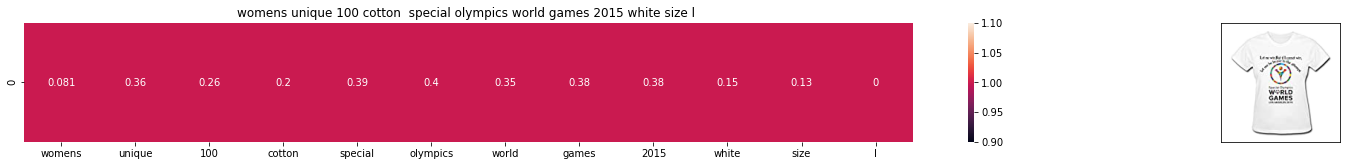

ASIN : B012YX2ZPI
Title : womens unique 100 cotton  special olympics world games 2015 white size l 
BRAND : HX-Kingdom Fashion T-shirts
Cosine distance from the given image : 0.0


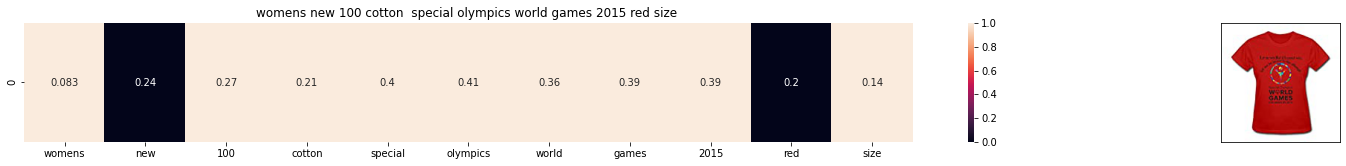

ASIN : B012YX3I5E
Title : womens new 100 cotton  special olympics world games 2015 red size 
BRAND : HX-Kingdom Fashion T-shirts
Cosine distance from the given image : 0.12748023262076247


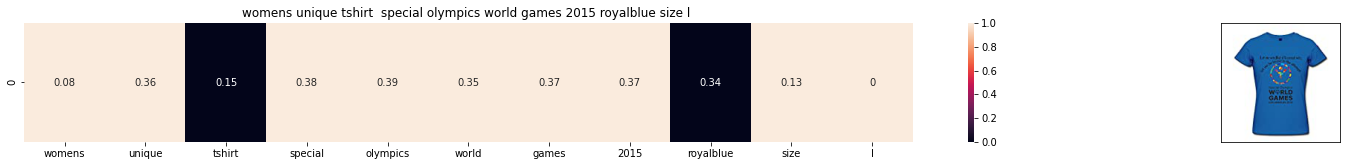

ASIN : B012YX4TVG
Title : womens unique tshirt  special olympics world games 2015 royalblue size l 
BRAND : HX-Kingdom Fashion T-shirts
Cosine distance from the given image : 0.13536909031182864


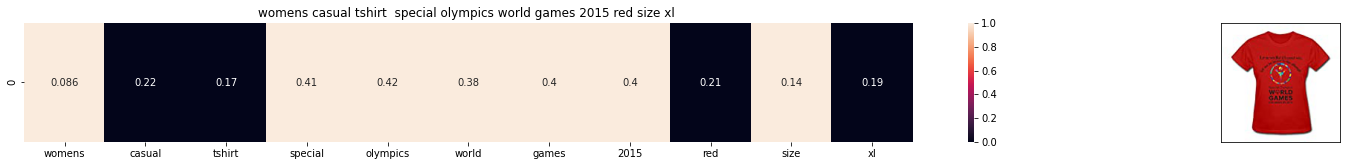

ASIN : B012YX3XTU
Title : womens casual tshirt  special olympics world games 2015 red size xl 
BRAND : HX-Kingdom Fashion T-shirts
Cosine distance from the given image : 0.21016440907603773


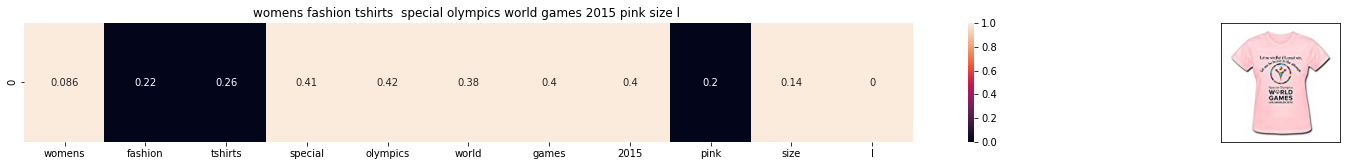

ASIN : B012YX26Q6
Title : womens fashion tshirts  special olympics world games 2015 pink size l 
BRAND : HX-Kingdom Fashion T-shirts
Cosine distance from the given image : 0.21117436376458143


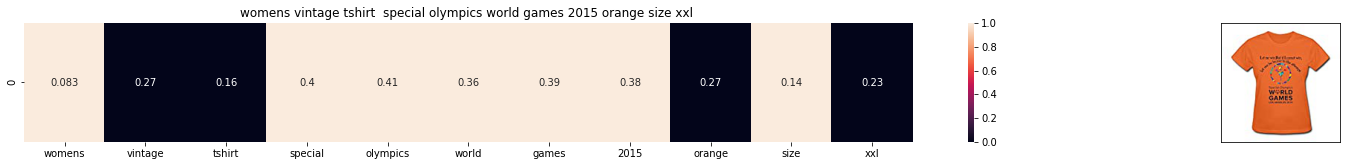

ASIN : B012YX4LVE
Title : womens vintage tshirt  special olympics world games 2015 orange size xxl 
BRAND : HX-Kingdom Fashion T-shirts
Cosine distance from the given image : 0.24248242223444771


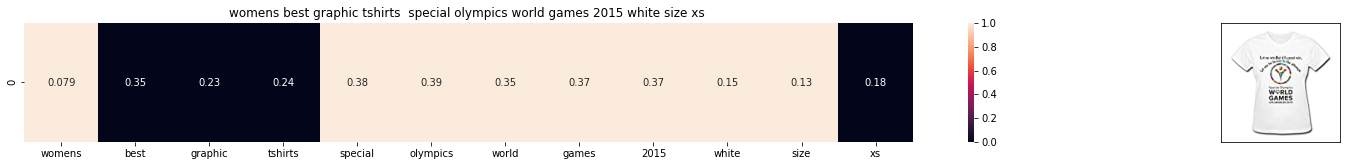

ASIN : B012YX2M3I
Title : womens best graphic tshirts  special olympics world games 2015 white size xs 
BRAND : HX-Kingdom Fashion T-shirts
Cosine distance from the given image : 0.2514695654654272


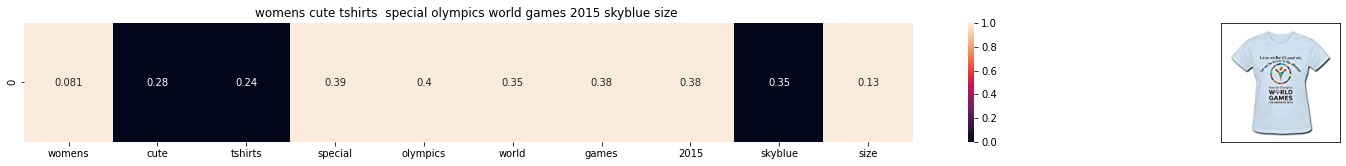

ASIN : B012YX30T8
Title : womens cute tshirts  special olympics world games 2015 skyblue size 
BRAND : HX-Kingdom Fashion T-shirts
Cosine distance from the given image : 0.2597537539364472


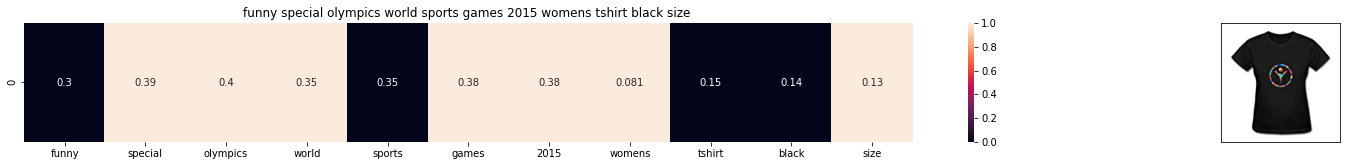

ASIN : B01338MTHM
Title : funny special olympics world sports games 2015 womens tshirt black size 
BRAND : MAM2 Arts
Cosine distance from the given image : 0.2611008091810678


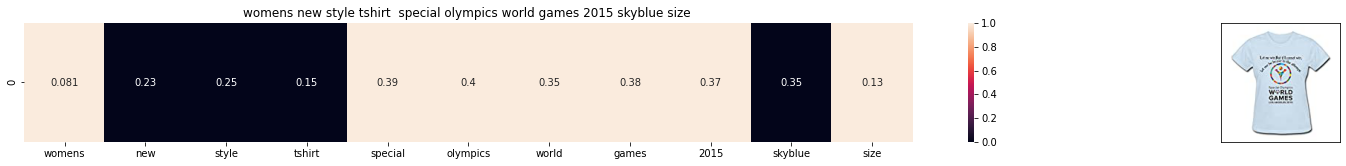

ASIN : B012YX2OJU
Title : womens new style tshirt  special olympics world games 2015 skyblue size 
BRAND : HX-Kingdom Fashion T-shirts
Cosine distance from the given image : 0.26253407204670487


In [ ]:
def tfidf_model(doc_id, num_results):

    pairwise_dist = pairwise_distances(tfidf_title_features, tfidf_title_features[doc_id], metric='cosine')

    # np.argsort sẽ trả về các chỉ số của khoảng cách nhỏ nhất
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists sẽ lưu trữ những khoảng cách nhỏ nhất
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame chỉ số của  khu vực nhỏ nhất
    df_indices = list(data.index[indices])



    for i in range(0,len(indices)):
        get_result(indices[i], data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'tfidf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Title :',data['title'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Cosine distance from the given image :', pdists[i])
        print('='*125)
tfidf_model(1,10)
# trong bản đồ heatmap đầu ra, mỗi giá trị đại diện cho các giá trị tfidf của từ label, màu đại diện cho giao điểm với title input

## 2.3  IDF based product similarity

In [ ]:
idf_title_vectorizer = CountVectorizer()
idf_title_features = idf_title_vectorizer.fit_transform(data['title'])

# idf_title_features.shape = #data_points * #words_in_corpus
# CountVectorizer().fit_transform(courpus) trả về ma trận thứ nguyên khác nhau #data_points * #words_in_corpus
# idf_title_features[doc_id, index_of_word_in_corpus] = số lần từ xuất hiện trong tài liệu đó

In [ ]:
def n_containing(word):
    # trả lại số lượng tài liệu có từ đã cho
    return sum(1 for blob in data['title'] if word in blob.split())

def idf(word):
    # idf = log(#số lượng doc / #trả lại số lượng tài liệu có từ đã cho)
    return math.log(data.shape[0] / (n_containing(word)))

In [ ]:
start_time = time.clock()
# chuyển đổi giá trị sang dạng float
idf_title_features  = idf_title_features.astype(np.float)

for i in idf_title_vectorizer.vocabulary_.keys():
    # cho mỗi từ trong cả kho dữ liệu ta có  idf value
    idf_val = idf(i)
    
    # để tính idf_title_features chúng ta cần thay thế các giá trị đếm bằng các giá trị idf của từ
    # idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0] sẽ trả lại tất cả các tài liệu có từ tôi trình bày
    for j in idf_title_features[:, idf_title_vectorizer.vocabulary_[i]].nonzero()[0]:
        
        # chúng tôi thay thế các giá trị đếm của từ i trong tài liệu j bằng idf_value của từ i
        # idf_title_features[doc_id, index_of_word_in_courpus] = idf value of word
        idf_title_features[j,idf_title_vectorizer.vocabulary_[i]] = idf_val
print(time.clock() - start_time, "seconds")      

185.846749 seconds


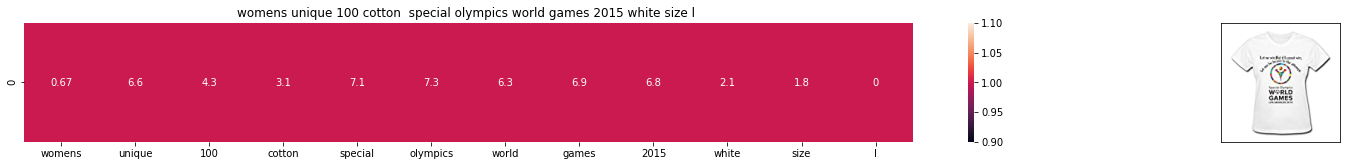

ASIN : B012YX2ZPI
Brand : HX-Kingdom Fashion T-shirts
cosine distance from the given image : 0.0


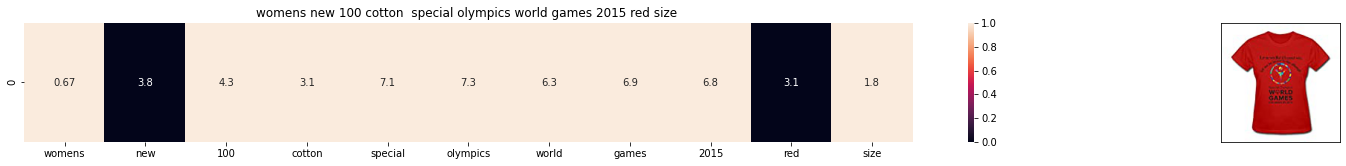

ASIN : B012YX3I5E
Brand : HX-Kingdom Fashion T-shirts
cosine distance from the given image : 0.11689768372442932


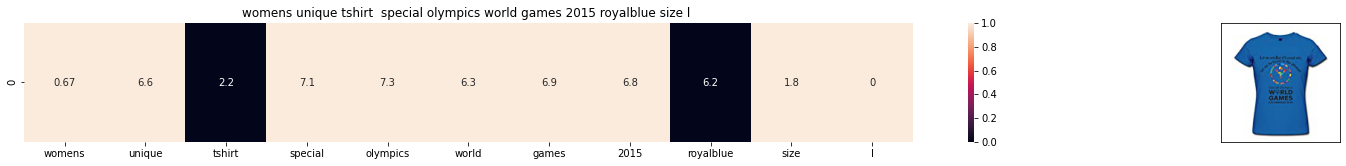

ASIN : B012YX4TVG
Brand : HX-Kingdom Fashion T-shirts
cosine distance from the given image : 0.11853579367127587


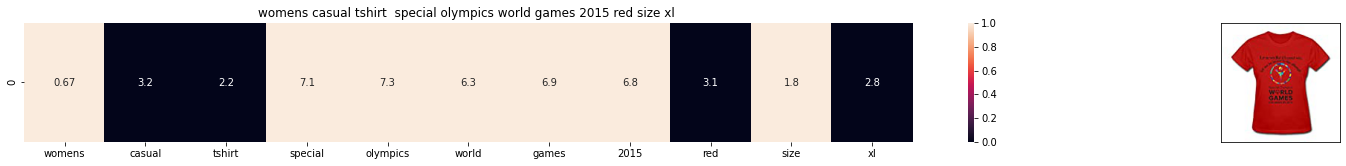

ASIN : B012YX3XTU
Brand : HX-Kingdom Fashion T-shirts
cosine distance from the given image : 0.18128098494125844


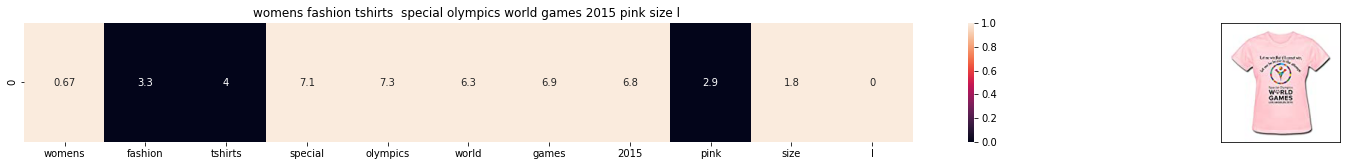

ASIN : B012YX26Q6
Brand : HX-Kingdom Fashion T-shirts
cosine distance from the given image : 0.18703129901860827


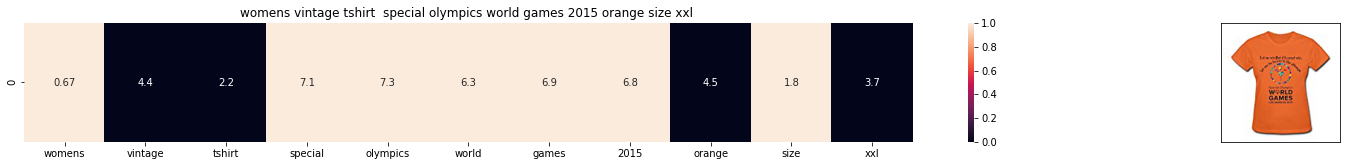

ASIN : B012YX4LVE
Brand : HX-Kingdom Fashion T-shirts
cosine distance from the given image : 0.21734539146124388


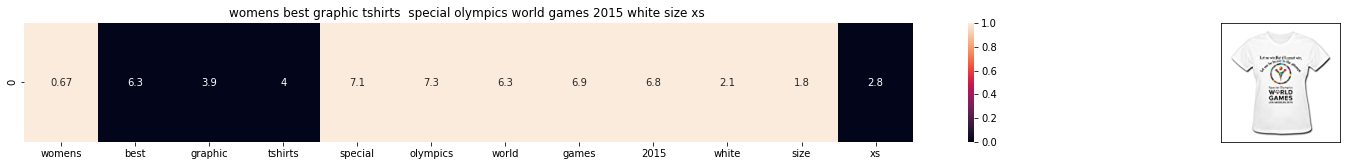

ASIN : B012YX2M3I
Brand : HX-Kingdom Fashion T-shirts
cosine distance from the given image : 0.23573703617537722


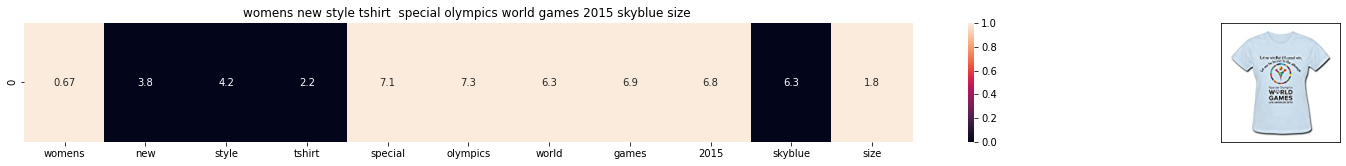

ASIN : B012YX2OJU
Brand : HX-Kingdom Fashion T-shirts
cosine distance from the given image : 0.241439205517873


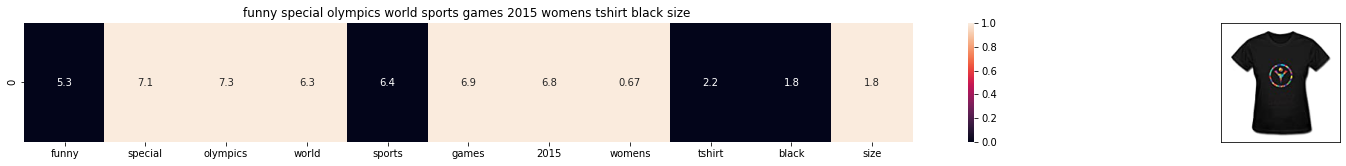

ASIN : B01338MTHM
Brand : MAM2 Arts
cosine distance from the given image : 0.24160690973313725


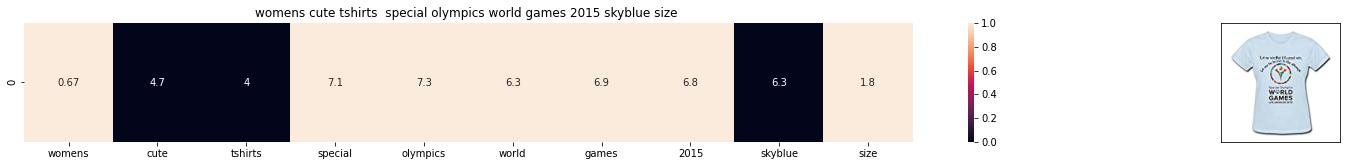

ASIN : B012YX30T8
Brand : HX-Kingdom Fashion T-shirts
cosine distance from the given image : 0.242499878867661


In [ ]:
def idf_model(doc_id, num_results):
    # doc_id: id của sản phẩm trong kho tài liệu nhất định
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(idf_title_features,idf_title_features[doc_id], metric='cosine')


     # np.argsort sẽ trả về các chỉ số của khoảng cách nhỏ nhất
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists sẽ lưu trữ những khoảng cách nhỏ nhất
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame chỉ số của  khu vực nhỏ nhất
    df_indices = list(data.index[indices])

    for i in range(0,len(indices)):
        get_result(indices[i],data['title'].loc[df_indices[0]], data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], 'idf')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print ('cosine distance from the given image :', pdists[i])
        print('='*125)

        
        
idf_model(1,10)
# trong bản đồ heatmap đầu ra, mỗi giá trị đại diện cho các giá trị idf của từ nhãn, màu đại diện cho giao điểm với title input

# 3  Text Semantics based product similarity

In [3]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
import scipy

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.

'''
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
'''


with open('Models/word2vec_model', 'rb') as handle:
    model = pickle.load(handle)


In [5]:
len(model['king'])

300

In [ ]:
# Các hàm hỗ trợ hiển thị

def get_word_vec(sentence, doc_id, m_name):
    # sentence : title của sản phẩm
    # doc_id: id tài liệu trong kho tài liệu 
    # m_name: thông tin mô hình nó sẽ nhận hai giá trị
        # if  m_name == 'avg', chúng tôi sẽ thêm mô hình [i], đại diện w2v của từ i
        # if m_name == 'weighted', chúng ta sẽ nhân mỗi w2v [word] với idf (word)
    vec = []
    for i in sentence.split():
        if i in vocab:
            if m_name == 'weighted' and i in  idf_title_vectorizer.vocabulary_:
                vec.append(idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[i]] * model[i])
            elif m_name == 'avg':
                vec.append(model[i])
        else:
            # nếu từ trong bản sao không có trong kho ngữ liệu google word2vec, chúng tôi sẽ bỏ qua nó
            vec.append(np.zeros(shape=(300,)))
    # chúng sẽ trả về một mảng hình dạng phức tạp (# số từ trong tiêu đề * 300) 300 = len (w2v_model [word])
    # mỗi hàng đại diện cho đại diện word2vec của mỗi từ (trọng số / trung bình) trong given sentence
    return  np.array(vec)

def get_distance(vec1, vec2):
    # vec1 = np.array(#number_of_words_title1 * 300), mỗi hàng là một vectơ có độ dài 300 tương ứng với mỗi từ trong tiêu đề
    # vec2 = np.array(#number_of_words_title2 * 300), mỗi hàng là một vectơ có độ dài 300 tương ứng với mỗi từ trong tiêu đề
    final_dist = []
    # đối với mỗi vectơ trong vec1,tôi tính khoảng cách (cosine) cho tất cả các vectơ trong vec2
    for i in vec1:
        dist = []
        for j in vec2:
            # np.linalg.norm(i-j) sẽ kết quả the euclidean distance giữa vectors i, j
            # scipy.spatial.distance.cosine(i-j) sẽ tính kết quả cosine distanse giữa vectors i, j
            dist.append(scipy.spatial.distance.cosine(i,j))
            # dist.append(scipy.spatial.distance.cdist(i,j,'cosine'))
            # dist.append(scipy.spatial.distance.euclidean(i,j))
            # dist.append(np.linalg.norm(i-j))
        final_dist.append(np.array(dist))
    # final_dist = np.array(# số từ trong tiêu đề1 * # số từ trong tiêu đề2)
    # final_dist[i,j] = cosine distance giữa vectors i, j
    return np.array(final_dist)


def heat_map_w2v(sentence1, sentence2, url, doc_id1, doc_id2, model):
    # sentance1 : title1, sản phẩm input
    # sentance2 : title2, sản phẩm gợi ý
    # url: url ảnh sản phẩm
    # doc_id1: id tài liệu của sản phẩm input
    # doc_id2: id tài liệu của sane phẩm được đề xuất
    # model:có thể 1 trong 2 giá trị: 1. avg 2. weighted
    
    #s1_vec = np.array(# number_of_words_title1 * 300), mỗi hàng là một vectơ (trọng số / trung bình) có độ dài 300 tương ứng với mỗi từ trong tiêu đề
    s1_vec = get_word_vec(sentence1, doc_id1, model)
    #s2_vec = np.array(# number_of_words_title1 * 300), mỗi hàng là một vectơ (trọng số / trung bình) có độ dài 300 tương ứng với mỗi từ trong tiêu đề
    s2_vec = get_word_vec(sentence2, doc_id2, model)

    # s1_s2_dist = np.array(# số từ trong tiêu đề1 * # số từ trong tiêu đề2)
    # s1_s2_dist[i,j] =  khoảng cách giữa words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
    print(s1_s2_dist[2,1],s1_s2_dist[2,2],s1_s2_dist[2,3])
    
    
    # chia toàn bộ hình thành 2 phần (Phần thứ nhất hiển thị bản đồ nhiệt, Phần thứ hai hiển thị hình ảnh quần áo)
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    ax = plt.subplot(gs[0])
    # đóng gói bản đồ heatmap dựa trên khoảng cách theo cặp
    ax = sns.heatmap(np.round(s1_s2_dist,4), annot=True)
    # đặt nhãn trục x làm tiêu đề sản phẩm được đề xuất
    ax.set_xticklabels(sentence2.split())
    # đặt nhãn trục y làm tiêu đề phần sản phẩm  đầu vào
    ax.set_yticklabels(sentence1.split())
    # đặt tiêu đề làm tiêu đề sản phẩm được đề xuất
    ax.set_title(sentence2)
    
    ax = plt.subplot(gs[1])
    # chúng tôi xóa tất cả các lưới và nhãn trục cho hình ảnh
    ax.grid(False)
    ax.set_xticks([])
    ax.set_yticks([])
    display_img(url, ax, fig)
    
    plt.show()

In [ ]:
# vocab = lưu trữ tất cả các từ có trong mô hình google w2v
# vocab = model.wv.vocab.keys() # if you are using Google word2Vec

vocab = model.keys()
# hàm này sẽ thêm các vectơ của mỗi từ và trả về vectơ trung bình của sentence đã cho
def build_avg_vec(sentence, num_features, doc_id, m_name):
    # sentace: title của sản phẩm
    # num_features: chiều dài của vector word2vec, các giá trị của nó = 300
    # m_name: thông tin mô hình nó sẽ nhận hai giá trị
        # if  m_name == 'avg', sẽ nối mô hình [i], đại diện w2v của từ i
        # if m_name == 'weighted', tôi sẽ nhân mỗi w2v [word] với idf (word)

    featureVec = np.zeros((num_features,), dtype="float32")
    # tôi sẽ phức tạp hóa một vectơ có kích thước 300 với tất cả các số không
    #  tôi thêm từng từ2vec (wordi) vào fetureVec này
    nwords = 0
    
    for word in sentence.split():
        nwords += 1
        if word in vocab:
            if m_name == 'weighted' and word in  idf_title_vectorizer.vocabulary_:
                featureVec = np.add(featureVec, idf_title_features[doc_id, idf_title_vectorizer.vocabulary_[word]] * model[word])
            elif m_name == 'avg':
                featureVec = np.add(featureVec, model[word])
    if(nwords>0):
        featureVec = np.divide(featureVec, nwords)
    # trả về vectơ trung bình của given sentance
    return featureVec

### 3 .2 Average Word2Vec product similarity.

In [ ]:
doc_id = 0
w2v_title = []
# đối với mỗi tiêu đề, tôi xây dựng biểu diễn vectơ trung bình
for i in data['title']:
    w2v_title.append(build_avg_vec(i, 300, doc_id,'avg'))
    doc_id += 1

# w2v_title = np.array(# số tài liệu trong Courpus * 300), mỗi hàng tương ứng với một tài liệu
w2v_title = np.array(w2v_title)


nan nan nan


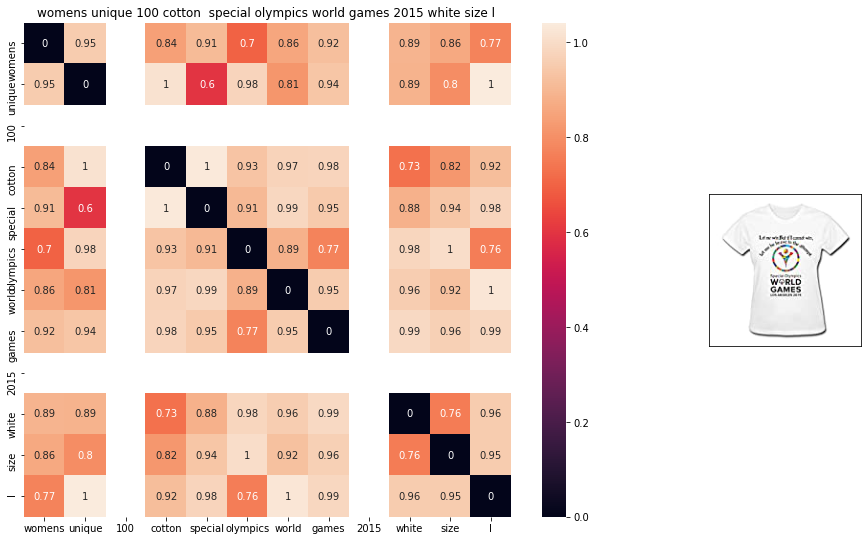

ASIN : B012YX2ZPI
BRAND : HX-Kingdom Fashion T-shirts
Cosine distance from given input image : 0.0
nan nan nan


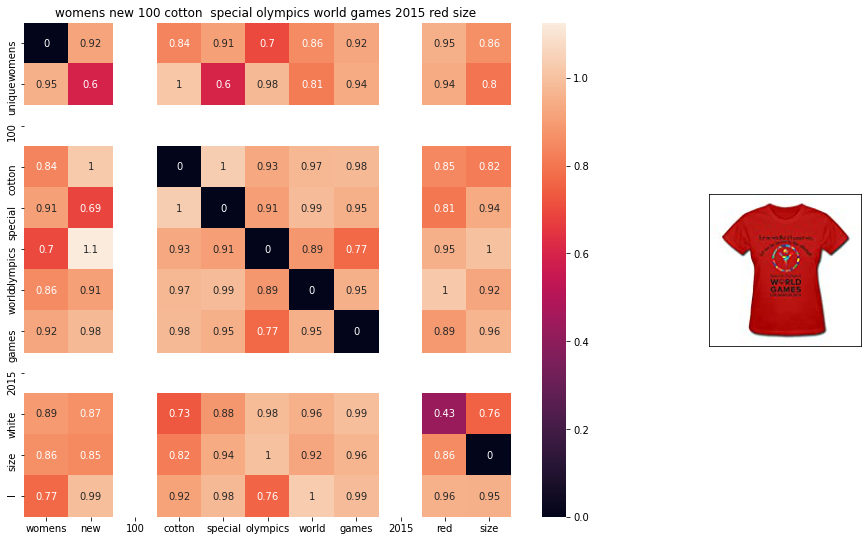

ASIN : B012YX3I5E
BRAND : HX-Kingdom Fashion T-shirts
Cosine distance from given input image : 0.05564171
nan nan nan


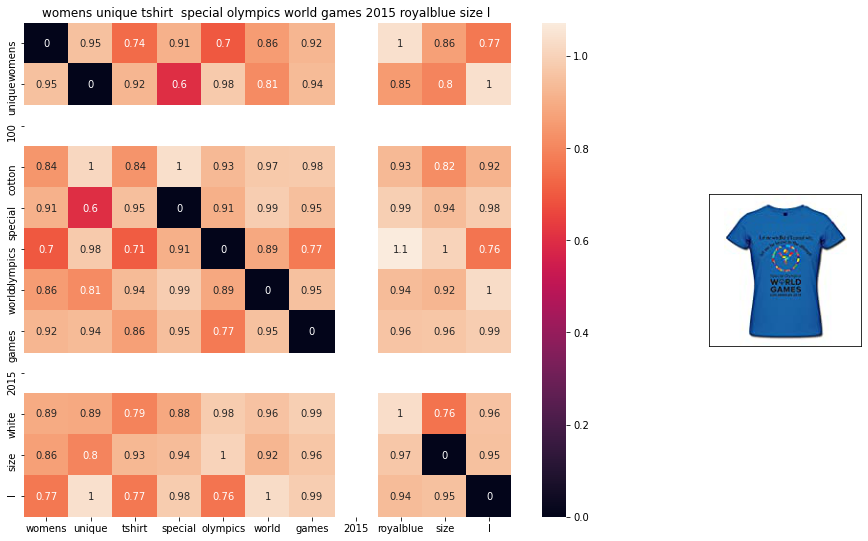

ASIN : B012YX4TVG
BRAND : HX-Kingdom Fashion T-shirts
Cosine distance from given input image : 0.099850416
nan nan nan


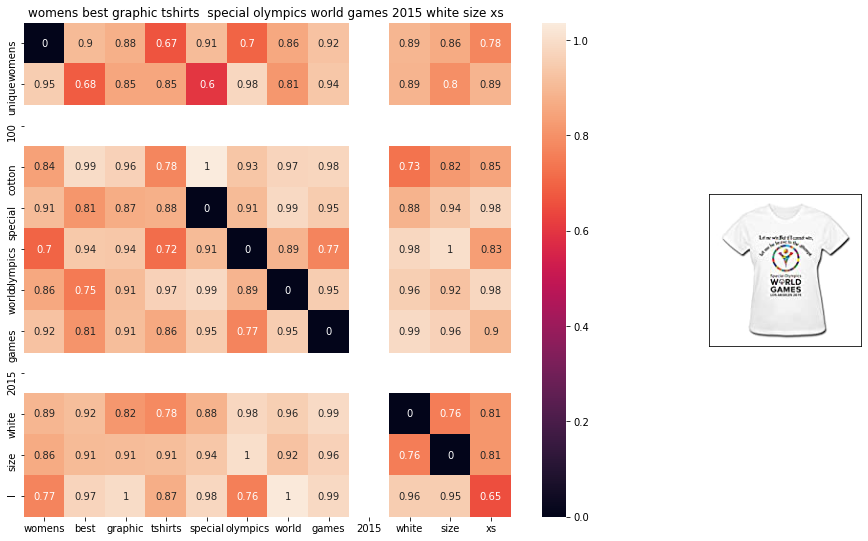

ASIN : B012YX2M3I
BRAND : HX-Kingdom Fashion T-shirts
Cosine distance from given input image : 0.118876696
nan nan nan


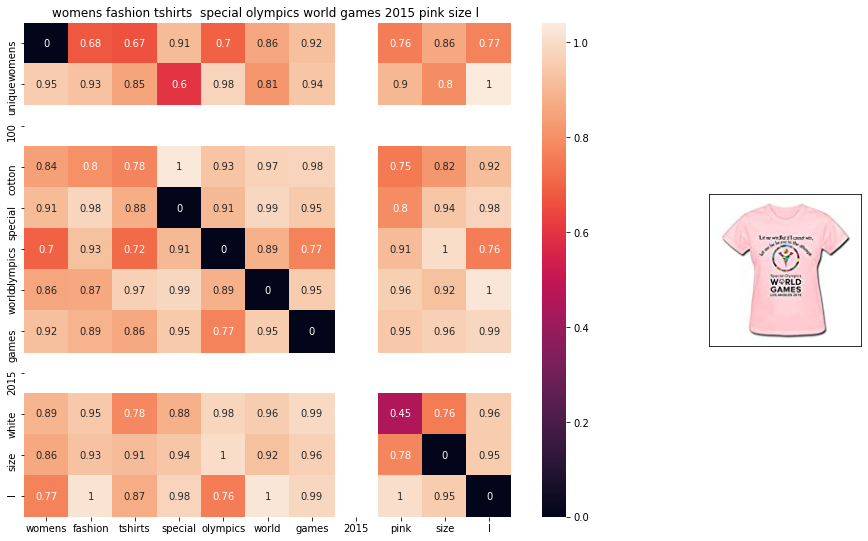

ASIN : B012YX26Q6
BRAND : HX-Kingdom Fashion T-shirts
Cosine distance from given input image : 0.119110465
nan nan nan


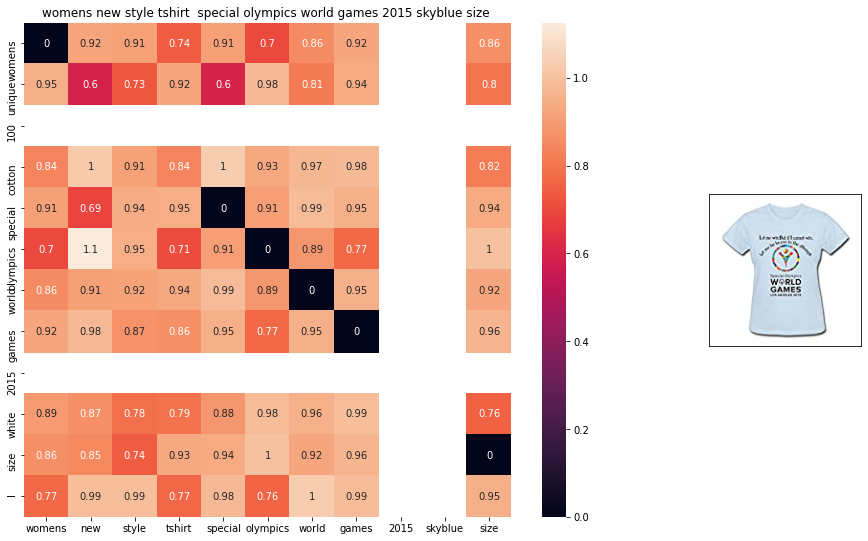

ASIN : B012YX2OJU
BRAND : HX-Kingdom Fashion T-shirts
Cosine distance from given input image : 0.13214928
nan nan nan


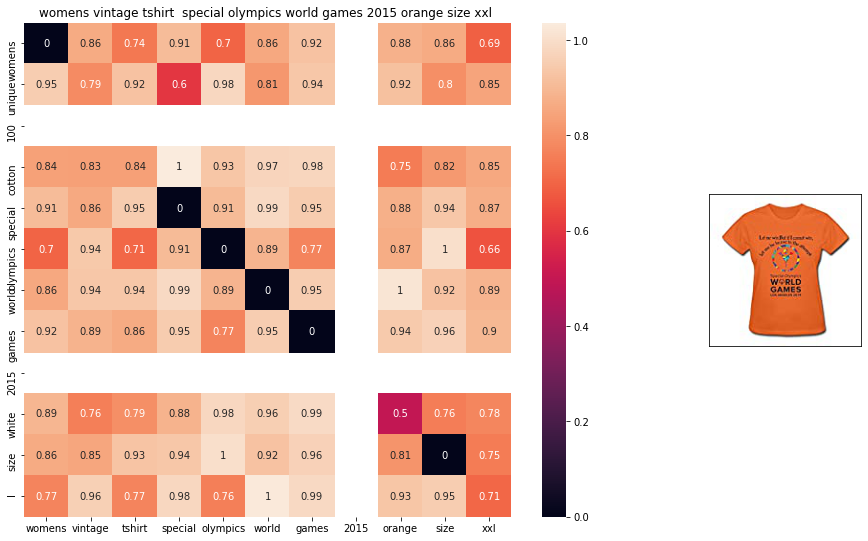

ASIN : B012YX4LVE
BRAND : HX-Kingdom Fashion T-shirts
Cosine distance from given input image : 0.1324768
nan nan nan


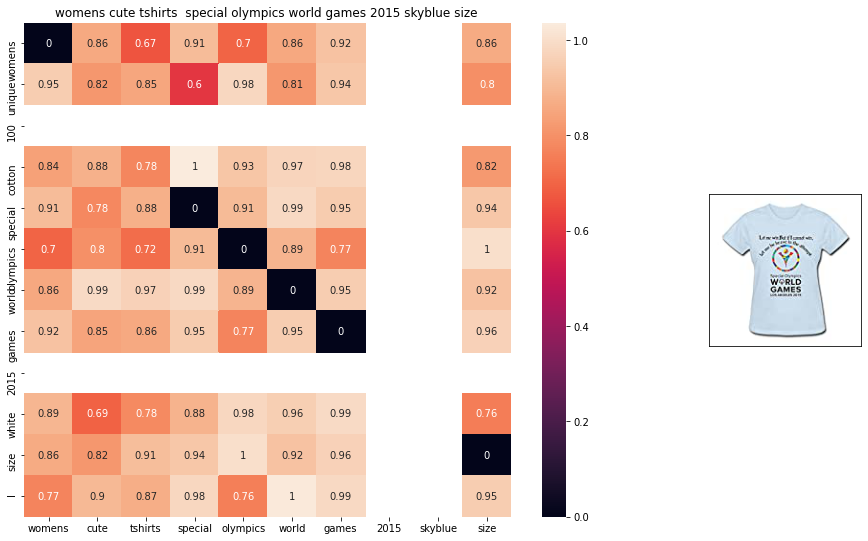

ASIN : B012YX30T8
BRAND : HX-Kingdom Fashion T-shirts
Cosine distance from given input image : 0.13431156
nan nan nan


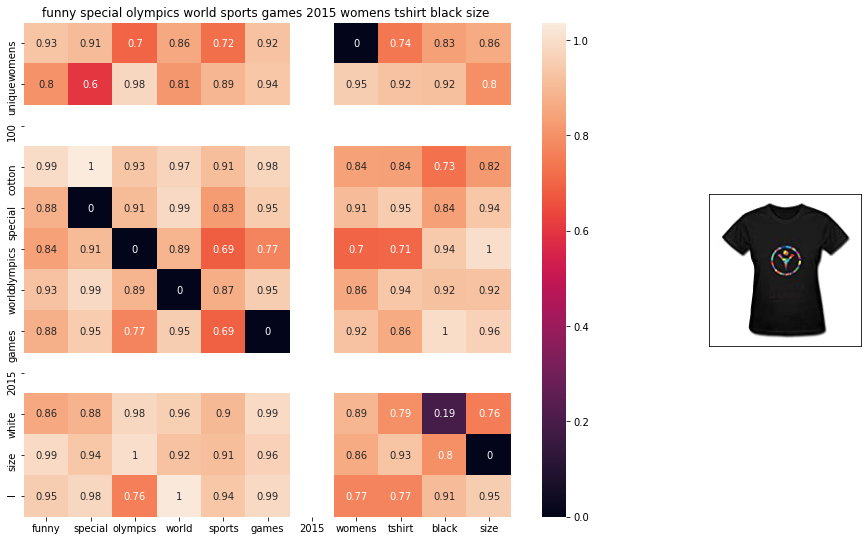

ASIN : B01338MTHM
BRAND : MAM2 Arts
Cosine distance from given input image : 0.13480884
nan nan nan


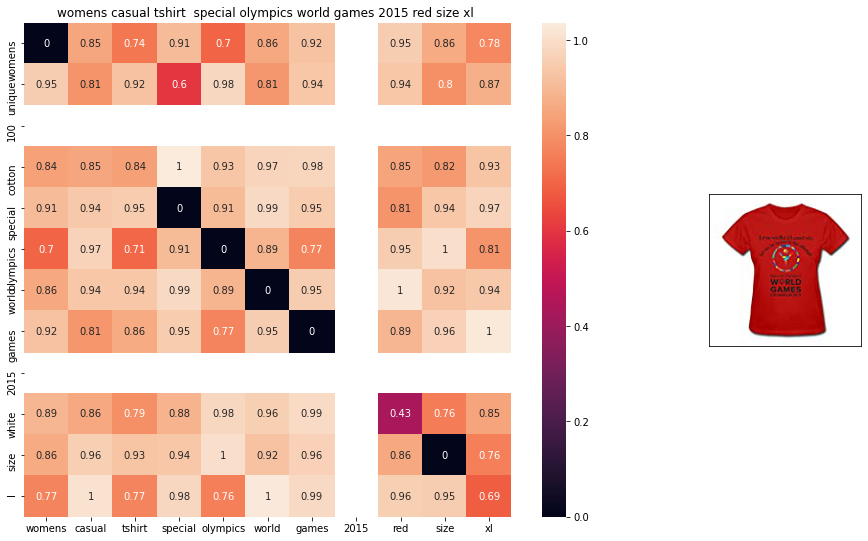

ASIN : B012YX3XTU
BRAND : HX-Kingdom Fashion T-shirts
Cosine distance from given input image : 0.14251113


In [ ]:
def avg_w2v_model(doc_id, num_results):
    # doc_id: item's id in given corpus
    
    
    pairwise_dist = pairwise_distances(w2v_title, w2v_title[doc_id].reshape(1,-1),metric='cosine')

    # np.argsort sẽ trả về stt item có khoảng cách nhỏ nhất
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists sẽ lưu trữ stt item khoảng cách nhỏ nhất
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #chuyển đổi sang dataframe
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'avg')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('BRAND :',data['brand'].loc[df_indices[i]])
        print ('Cosine distance from given input image :', pdists[i])
        print('='*125)

        
avg_w2v_model(1,10)
# trong heatmap , mỗi ô chứa khoảng cách cosine giữa hai từ i, j

### 3 .4  IDF weighted Word2Vec for product similarity

In [ ]:
doc_id = 0
w2v_title_weight = []
# đối với mỗi tiêu đề, chúng tôi xây dựng một biểu diễn vector có trọng số
for i in data['title']:
    w2v_title_weight.append(build_avg_vec(i, 300, doc_id,'weighted'))
    doc_id += 1
# w2v_title = np.array(# số tài liệu trong Courpus * 300), mỗi hàng tương ứng với một tài liệu
w2v_title_weight = np.array(w2v_title_weight)

nan nan nan


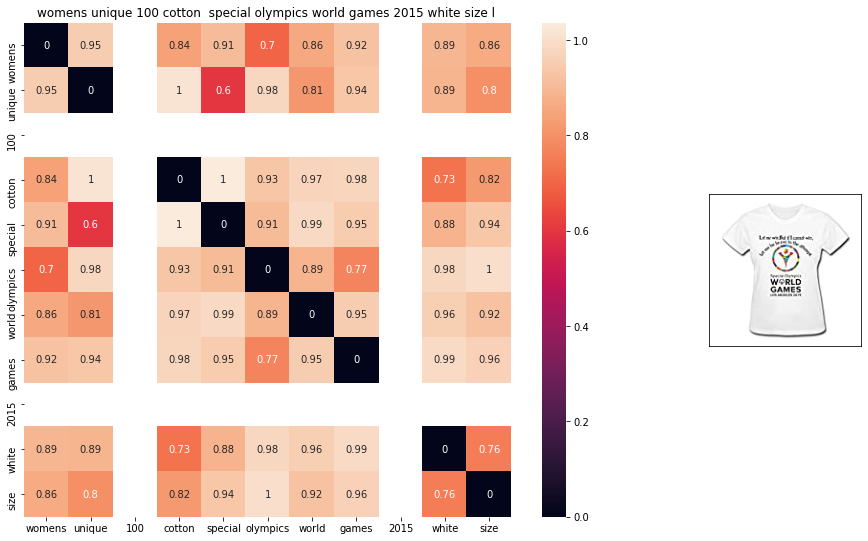

ASIN : B012YX2ZPI
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.0
nan nan nan


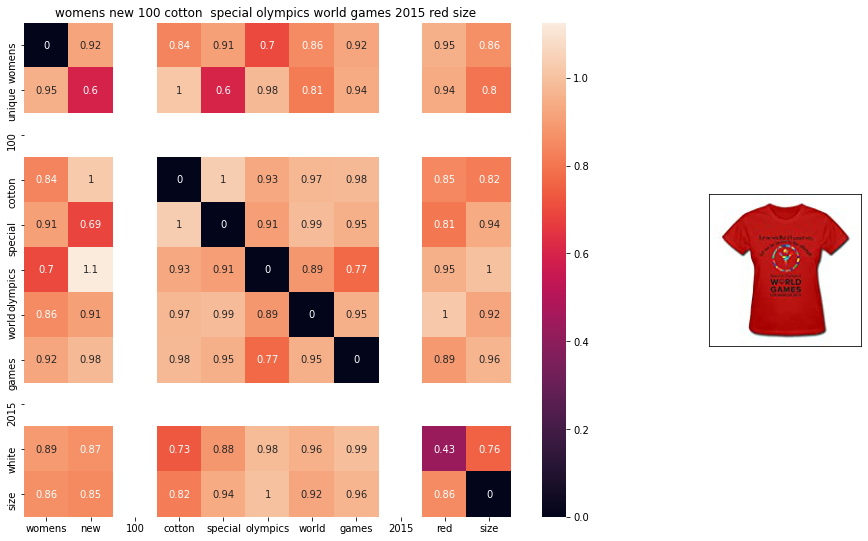

ASIN : B012YX3I5E
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.03939116
nan nan nan


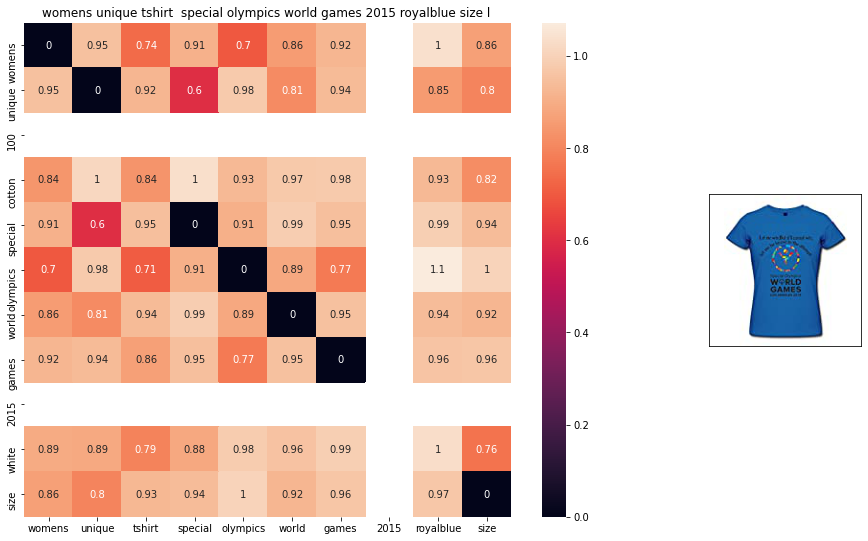

ASIN : B012YX4TVG
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.04484272
nan nan nan


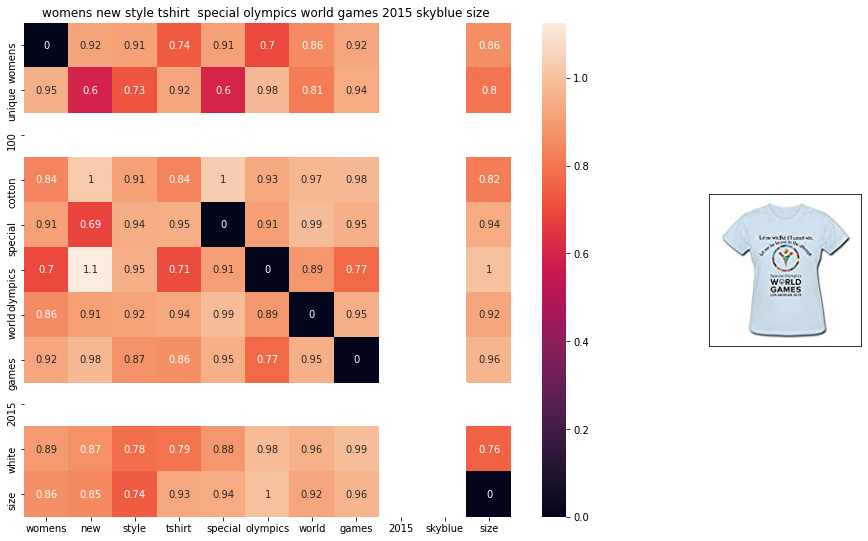

ASIN : B012YX2OJU
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.06632495
nan nan nan


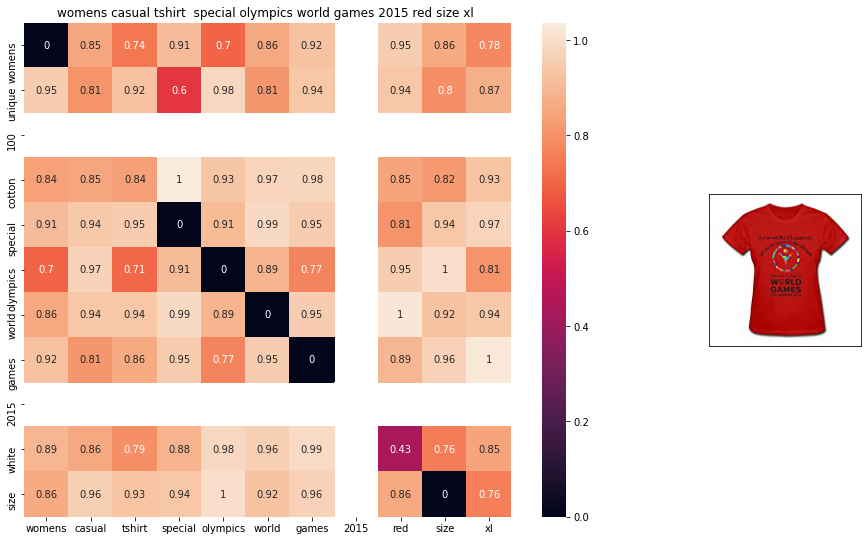

ASIN : B012YX3XTU
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.078341484
nan nan nan


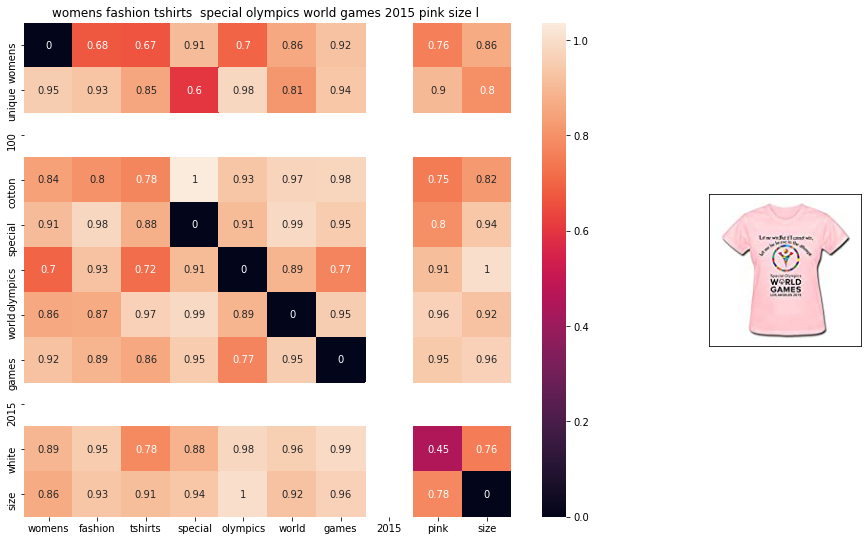

ASIN : B012YX26Q6
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.08702052
nan nan nan


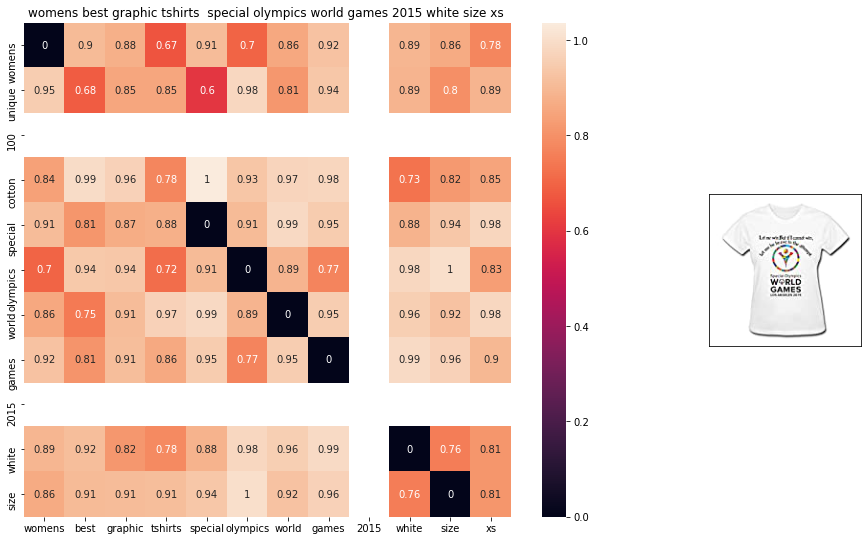

ASIN : B012YX2M3I
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.089340806
nan nan nan


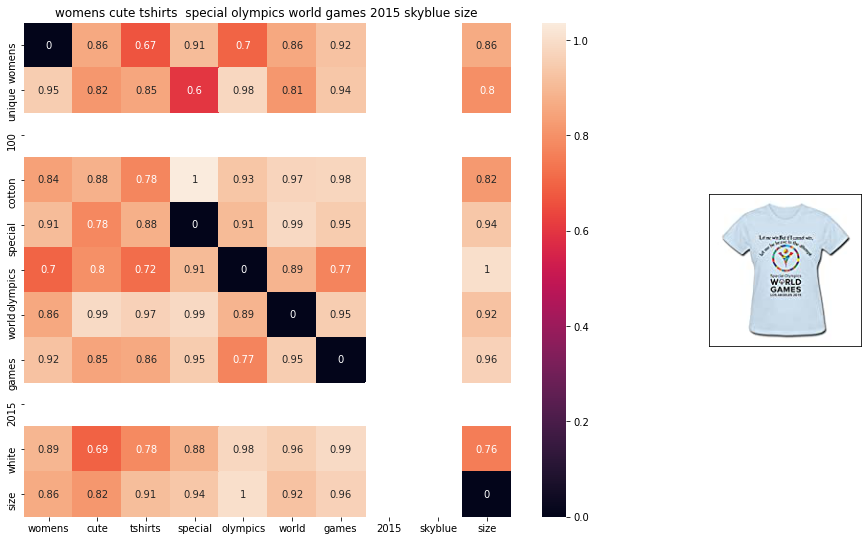

ASIN : B012YX30T8
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.089607716
nan nan nan


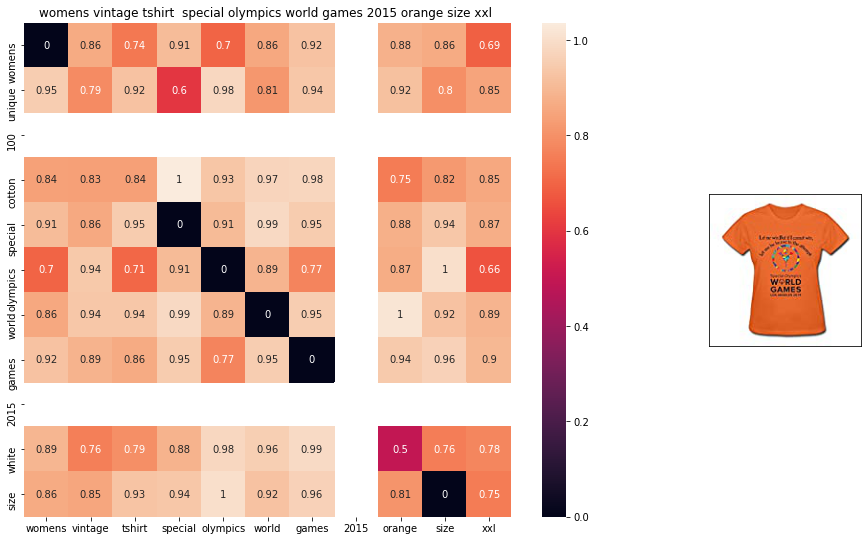

ASIN : B012YX4LVE
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.0914799
nan nan nan


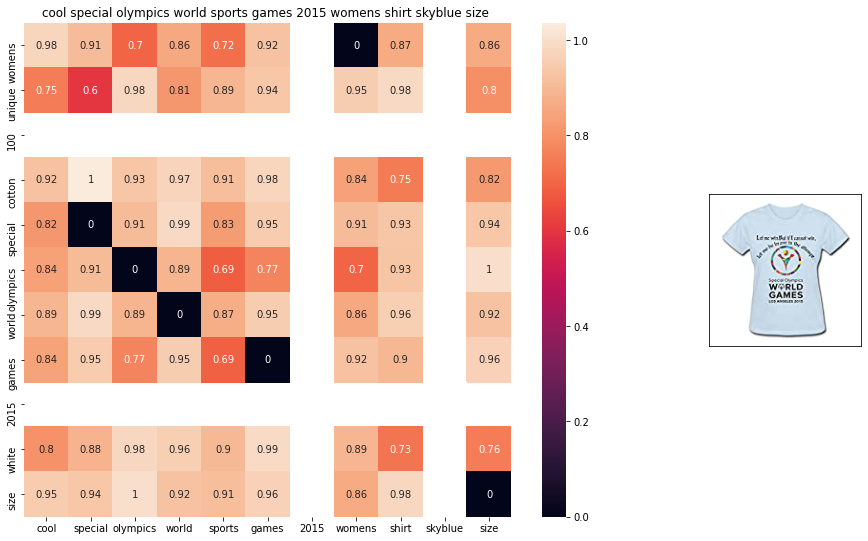

ASIN : B01338LWAM
Brand : MAM2 Arts
cosine distance from input : 0.09727669


In [ ]:
def weighted_w2v_model(doc_id, num_results):
    # doc_id: item's id in given corpus
    
    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    pairwise_dist = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1), metric='cosine')

    # np.argsort sẽ trả về các chỉ số của khoảng cách nhỏ nhất
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists sẽ lưu trữ những khoảng cách nhỏ nhất
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]

    #data frame chỉ số của khu vực nhỏ nhất
    df_indices = list(data.index[indices])
    
    for i in range(0, len(indices)):
        heat_map_w2v(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('cosine distance from input :', pdists[i])
        print('='*125)

weighted_w2v_model(1,10)

# trong bản đồ nhiệt cho trước, mỗi ô chứa khoảng cách cosine giữa các từ i, j

### 3 .6 Weighted similarity using brand and color.

In [ ]:
# một số giá trị brand trống.
# Need to replace Null with string "NULL"
data['brand'].fillna(value="Not given", inplace=True )

# replace spaces with hypen
brands = [x.replace(" ", "-") for x in data['brand'].values]
types = [x.replace(" ", "-") for x in data['product_type_name'].values]
colors = [x.replace(" ", "-") for x in data['color'].values]

brand_vectorizer = CountVectorizer()
brand_features = brand_vectorizer.fit_transform(brands)

type_vectorizer = CountVectorizer()
type_features = type_vectorizer.fit_transform(types)

color_vectorizer = CountVectorizer()
color_features = color_vectorizer.fit_transform(colors)

extra_features = hstack((brand_features, type_features, color_features)).tocsr()

In [ ]:
def heat_map_w2v_brand(sentance1, sentance2, url, doc_id1, doc_id2, df_id1, df_id2, model):
    
    # sentance1 : title1, sản phẩm input
    # sentance2 : title2, sản phẩm gợi ý
    # url:  image url
    # doc_id1: document id of sản phẩm input 
    # doc_id2: document id of sản phẩm gợi ý
    # df_id1: index of document1 in the data frame
    # df_id2: index of document2 in the data frame
    # model: có thể là hai giá trị , 1. avg 2. weighted
    
    #s1_vec = np.array(# number_of_words_title1 * 300), mỗi hàng là một vectơ (có trọng số / trung bình) có độ dài 300 tương ứng với mỗi từ trong tiêu đề
    s1_vec = get_word_vec(sentance1, doc_id1, model)
    #s2_vec = np.array(# number_of_words_title1 * 300), mỗi hàng là một vectơ (có trọng số / trung bình) có độ dài 300 tương ứng với mỗi từ trong tiêu đề
    s2_vec = get_word_vec(sentance2, doc_id2, model)
    
    # s1_s2_dist = np.array(# số từ trong tiêu đề1 * # số từ trong tiêu đề2)
    # s1_s2_dist[i,j] =  distance between words i, j
    s1_s2_dist = get_distance(s1_vec, s2_vec)
   
    # data_matrix = [['Asin','Brand', 'Color', 'Product type'],
    #            [data['asin'].loc[df_id1],brands[doc_id1], colors[doc_id1], types[doc_id1]], # input apparel's features
    #            [data['asin'].loc[df_id2],brands[doc_id2], colors[doc_id2], types[doc_id2]]] # recommonded apparel's features
    
    # colorscale = [[0, '#1d004d'],[.5, '#f2e5ff'],[1, '#f2e5d1']] # to color the headings of each column 
    
    # # we create a table with the data_matrix
    # table = ff.create_table(data_matrix, index=True, colorscale=colorscale)
    # # plot it with plotly
    # plotly.offline.iplot(table, filename='simple_table')
    
    # devide whole figure space into 25 * 1:10 grids
    # gs = gridspec.GridSpec(25,25)
    # fig = plt.figure(figsize=(25,5))
    gs = gridspec.GridSpec(2, 2, width_ratios=[4,1],height_ratios=[2,1]) 
    fig = plt.figure(figsize=(15,15))
    
    
    # in first 25*10 grids we plot heatmap
    ax1 = plt.subplot(gs[0])

    # ploting the heap map based on the pairwise distances
    ax1 = sns.heatmap(np.round(s1_s2_dist,6), annot=True)
    # set the x axis labels as recommended apparels title
    ax1.set_xticklabels(sentance2.split())
    # set the y axis labels as input apparels title
    ax1.set_yticklabels(sentance1.split())
    # set title as recommended apparels title
    ax1.set_title(sentance2)

    # in last 25 * 10:15 grids i display image
    ax2 = plt.subplot(gs[1])
    # i dont display grid lins and axis labels to images
    ax2.grid(False)
    ax2.set_xticks([])
    ax2.set_yticks([])
    
    # pass the url it display it
    display_img(url, ax2, fig)
    
    plt.show()

[0.         0.0446704  0.10302891 ... 0.94411783 0.94676919 0.94784012]
[   1   48   89 ... 8290 3640 2353]


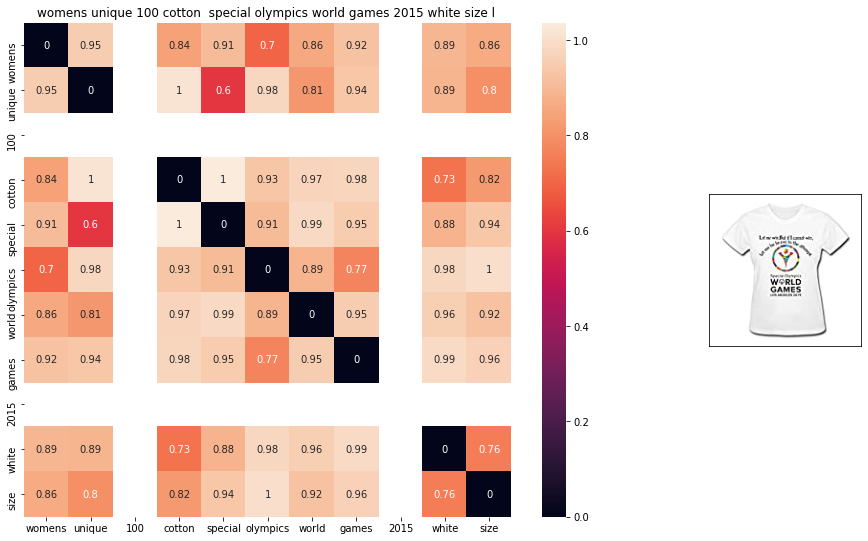

ASIN : B012YX2ZPI
Title : womens unique 100 cotton  special olympics world games 2015 white size l 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.0


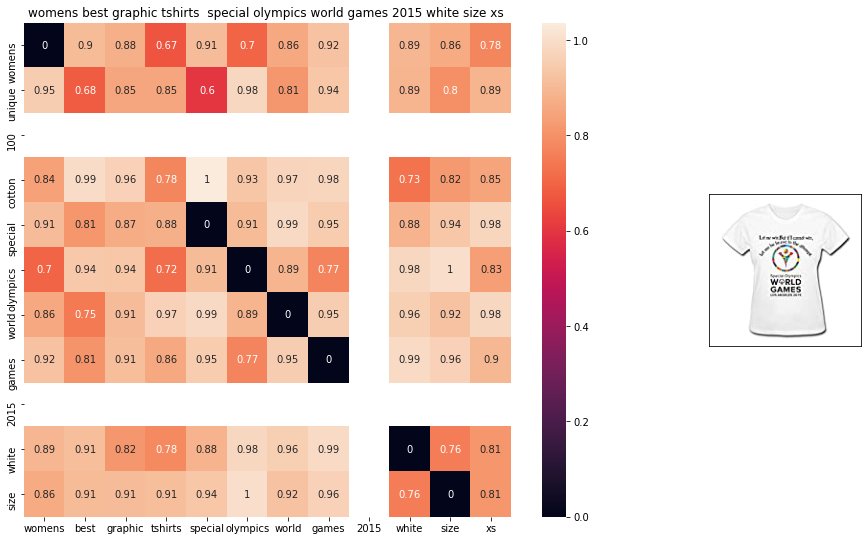

ASIN : B012YX2M3I
Title : womens best graphic tshirts  special olympics world games 2015 white size xs 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.04467040300369263


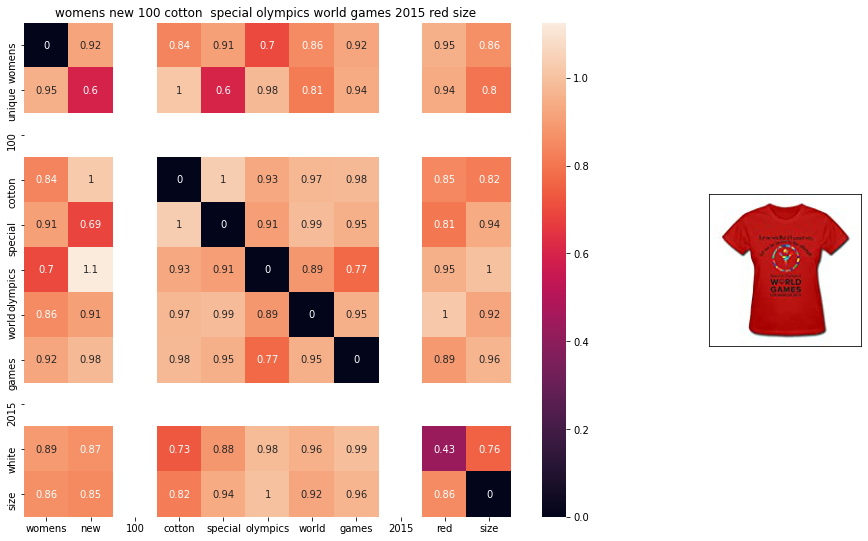

ASIN : B012YX3I5E
Title : womens new 100 cotton  special olympics world games 2015 red size 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.10302891333897897


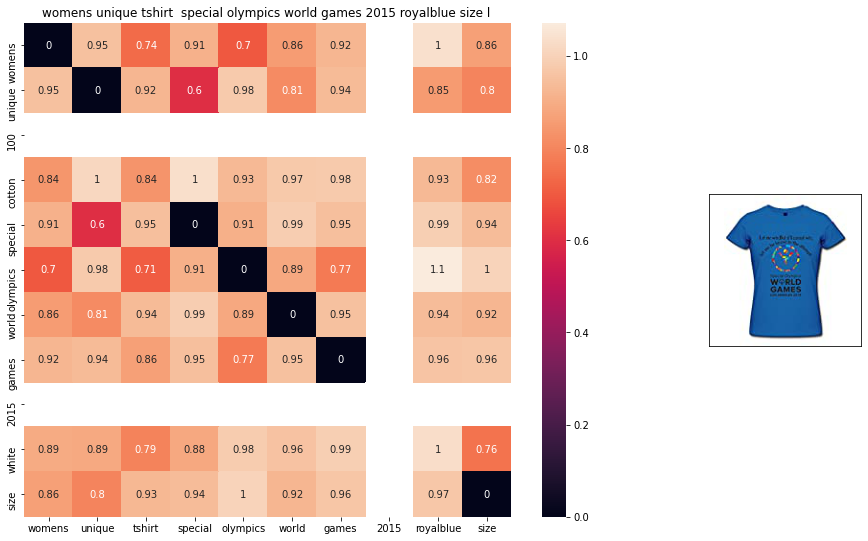

ASIN : B012YX4TVG
Title : womens unique tshirt  special olympics world games 2015 royalblue size l 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.10575469334920236


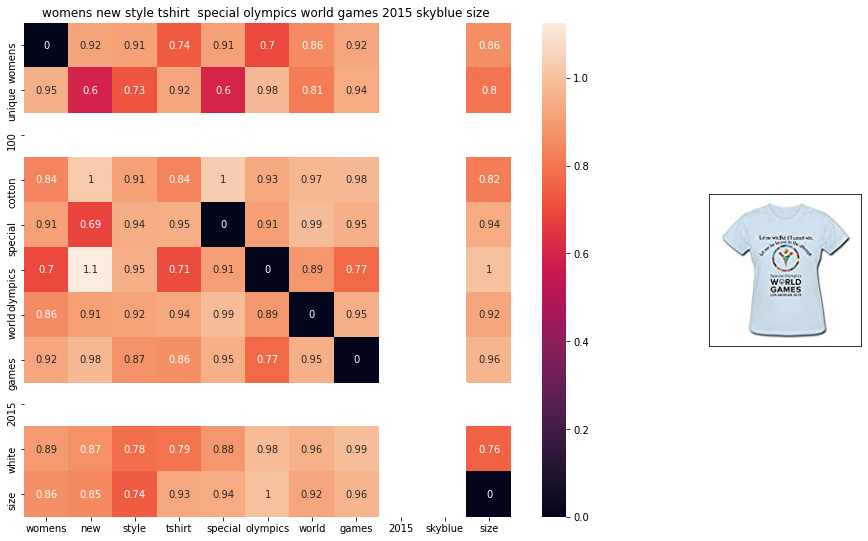

ASIN : B012YX2OJU
Title : womens new style tshirt  special olympics world games 2015 skyblue size 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.1164958079655964


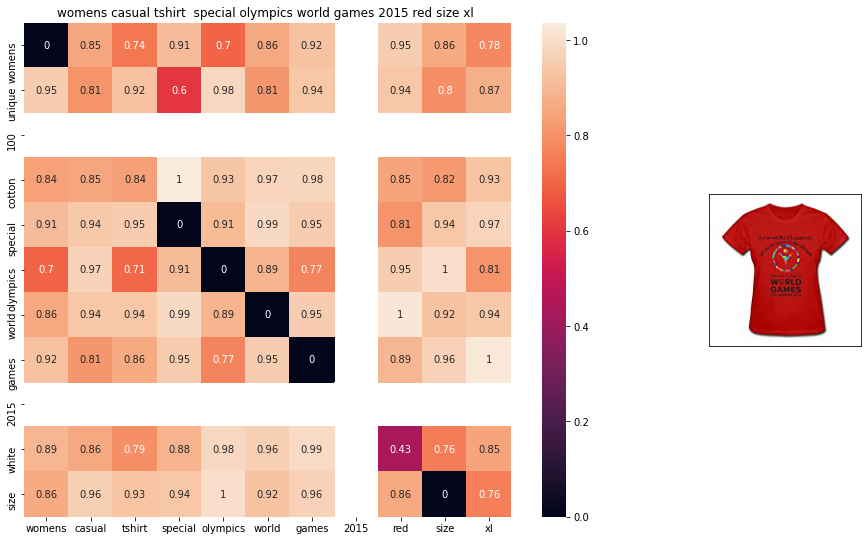

ASIN : B012YX3XTU
Title : womens casual tshirt  special olympics world games 2015 red size xl 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.12250407536824533


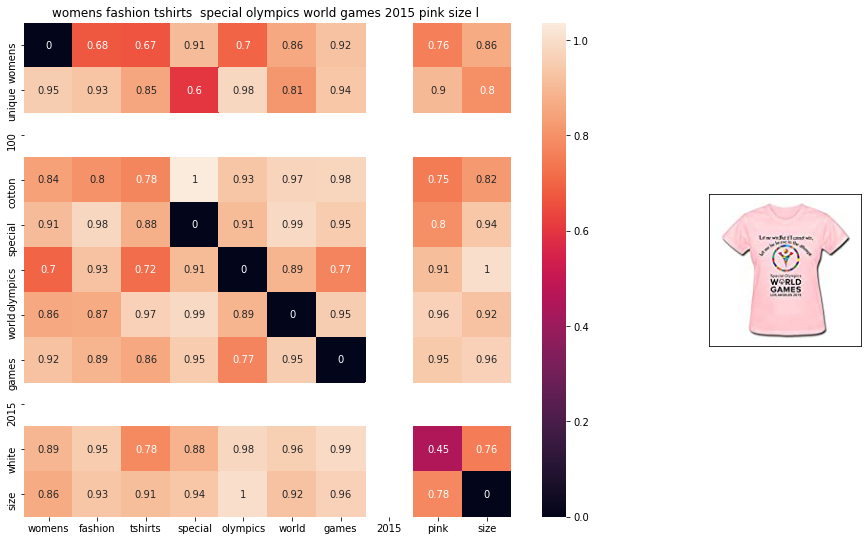

ASIN : B012YX26Q6
Title : womens fashion tshirts  special olympics world games 2015 pink size l 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.12684359153111763


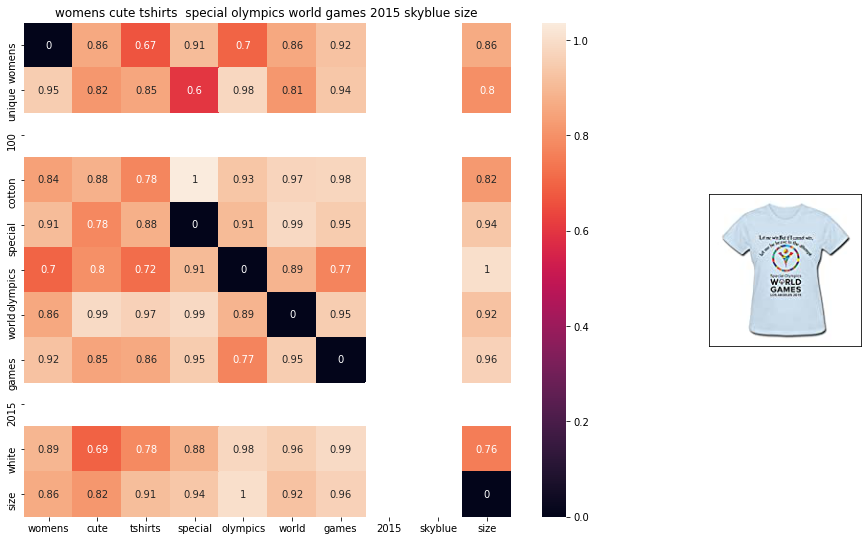

ASIN : B012YX30T8
Title : womens cute tshirts  special olympics world games 2015 skyblue size 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.12813719113667793


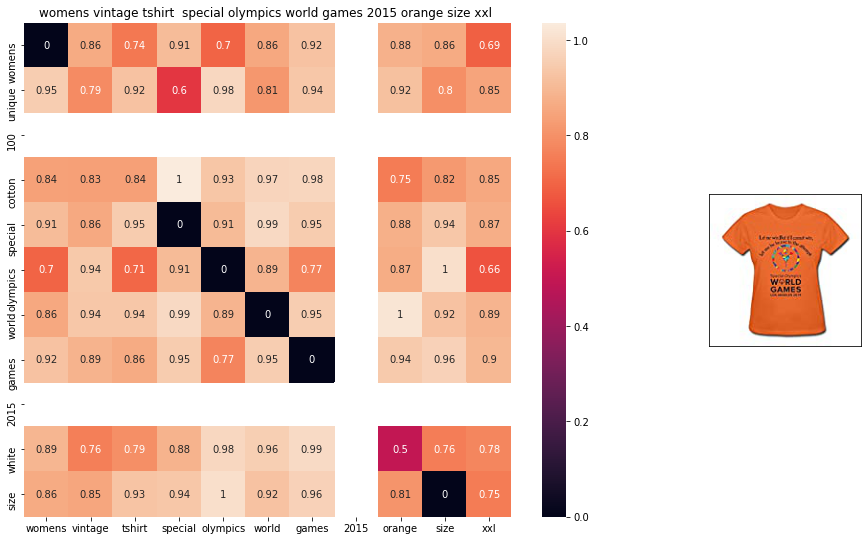

ASIN : B012YX4LVE
Title : womens vintage tshirt  special olympics world games 2015 orange size xxl 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.12907328208287544


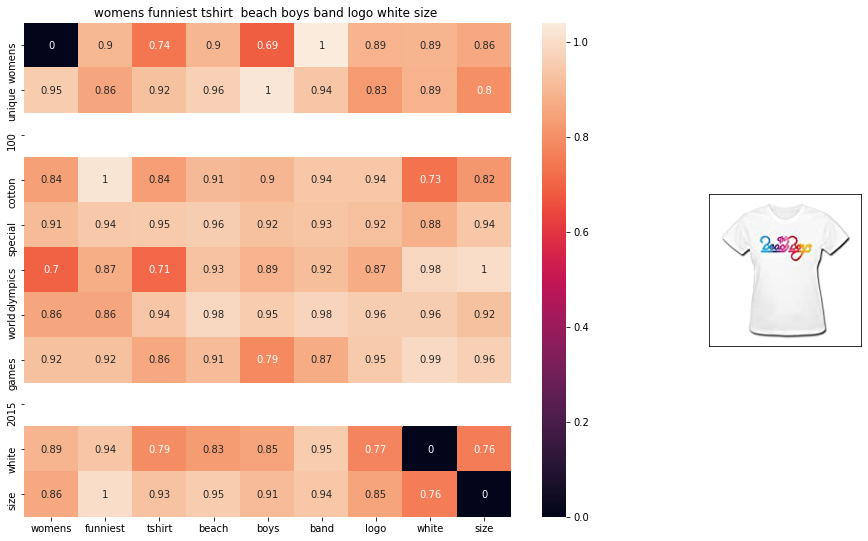

ASIN : B012HVCV38
Title : womens funniest tshirt  beach boys band logo white size 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.30874247550964357


In [ ]:
def idf_w2v_brand(doc_id, w1, w2, num_results):
    # doc_id: item's id in given corpus
    # w1: trọng số cho các tính năng w2v
    # w2: trọng số cho các đặc điểm thương hiệu và màu sắc

    # pairwise_dist will store the distance from given input apparel to all remaining apparels
    # the metric we used here is cosine, the coside distance is mesured as K(X, Y) = <X, Y> / (||X||*||Y||)
    # http://scikit-learn.org/stable/modules/metrics.html#cosine-similarity
    idf_w2v_dist  = pairwise_distances(w2v_title_weight, w2v_title_weight[doc_id].reshape(1,-1), metric='cosine')
    ex_feat_dist = pairwise_distances(extra_features, extra_features[doc_id], metric='cosine')
    pairwise_dist   = (w1 * idf_w2v_dist +  w2 * ex_feat_dist)/float(w1 + w2)

    # np.argsort sẽ trả về các chỉ số của khoảng cách nhỏ nhất
    indices = np.argsort(pairwise_dist.flatten())[0:num_results]
    #pdists sẽ lưu trữ những khoảng cách nhỏ nhất
    pdists  = np.sort(pairwise_dist.flatten())[0:num_results]
    
    #data frame chỉ số của khu vực nhỏ nhất
    df_indices = list(data.index[indices])
    x = pairwise_dist.flatten()
    print(np.sort(pairwise_dist.flatten()))
    print(np.argsort(pairwise_dist.flatten()))

    for i in range(0, len(indices)):
        heat_map_w2v_brand(data['title'].loc[df_indices[0]],data['title'].loc[df_indices[i]], data['medium_image_url'].loc[df_indices[i]], indices[0], indices[i],df_indices[0], df_indices[i], 'weighted')
        print('ASIN :',data['asin'].loc[df_indices[i]])
        print('Title :',data['title'].loc[df_indices[i]])
        print('Brand :',data['brand'].loc[df_indices[i]])
        print('cosine distance from input :', pdists[i])
        print('='*125)

idf_w2v_brand(1, 5, 5, 10)
# trong bản đồ nhiệt cho trước, mỗi ô chứa khoảng cách cosine giữa các từ i, j

16319
[  1  48 159 150  89 105  25 236  72 219]


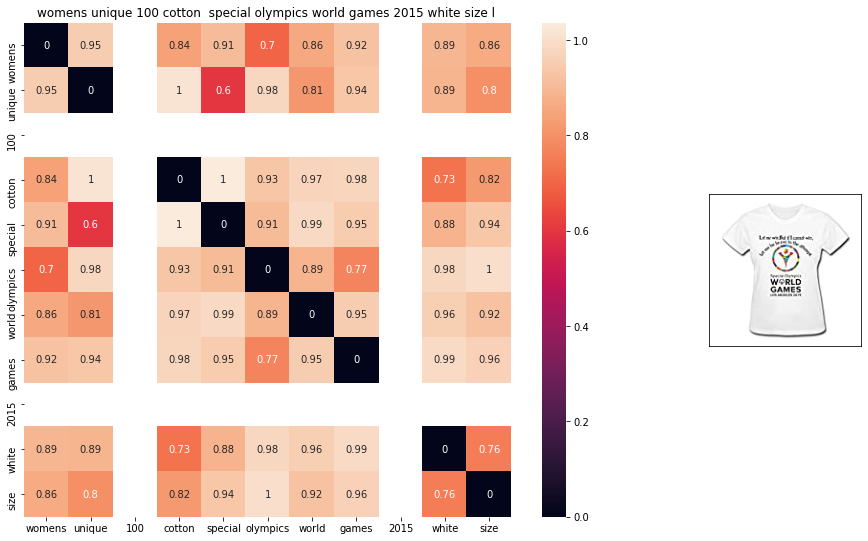

ASIN : B012YX2ZPI
Title : womens unique 100 cotton  special olympics world games 2015 white size l 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.0


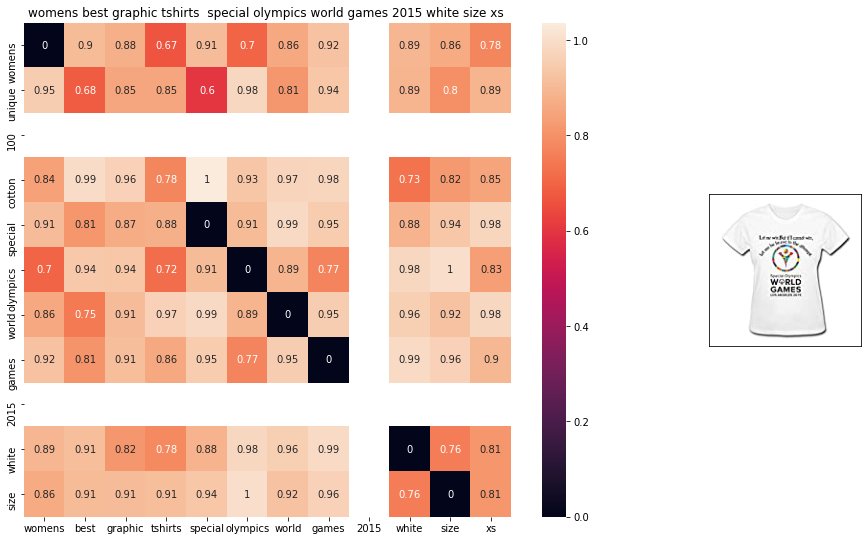

ASIN : B012YX2M3I
Title : womens best graphic tshirts  special olympics world games 2015 white size xs 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.0


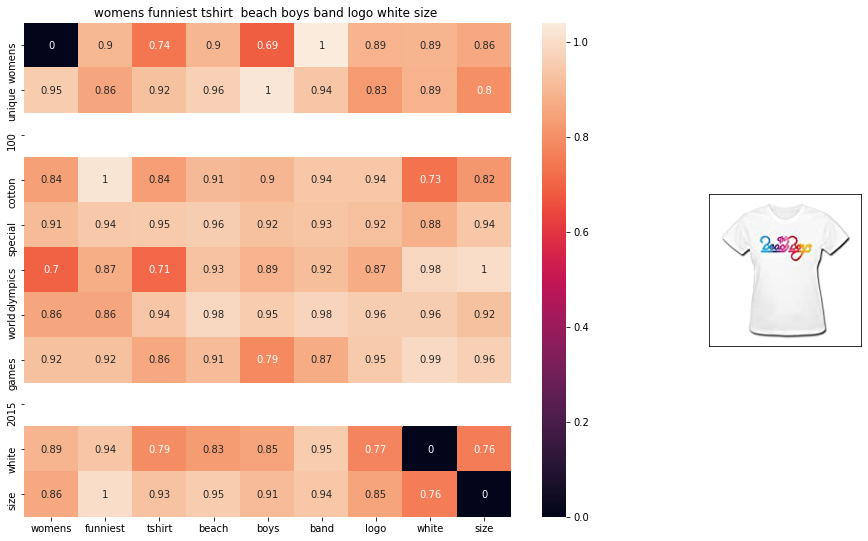

ASIN : B012HVCV38
Title : womens funniest tshirt  beach boys band logo white size 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.0


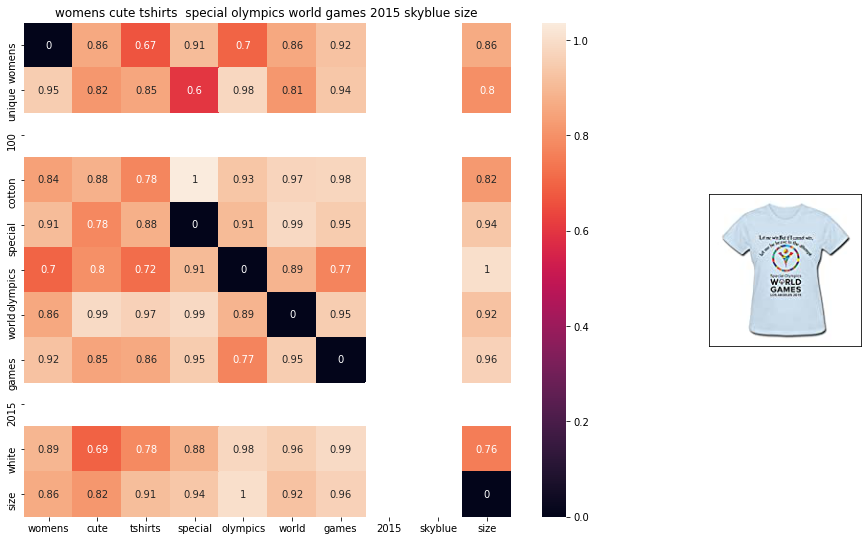

ASIN : B012YX30T8
Title : womens cute tshirts  special olympics world games 2015 skyblue size 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.1666666666666664


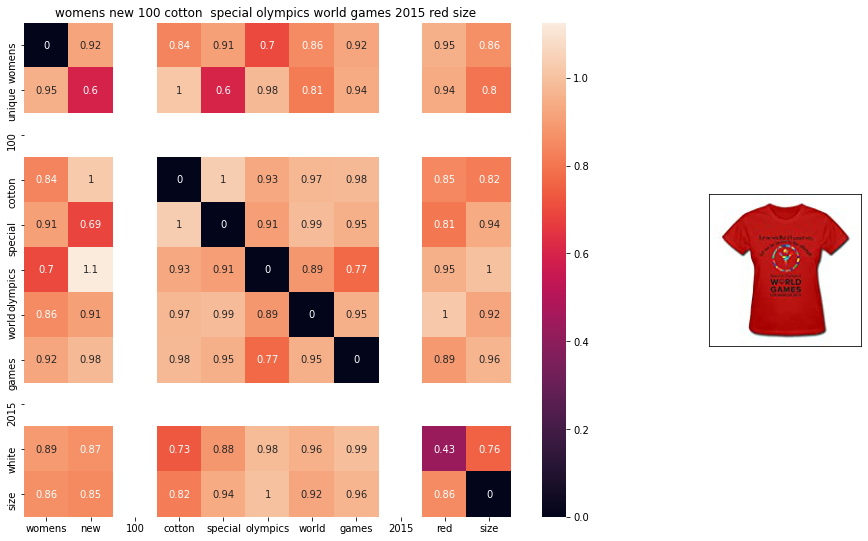

ASIN : B012YX3I5E
Title : womens new 100 cotton  special olympics world games 2015 red size 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.1666666666666664


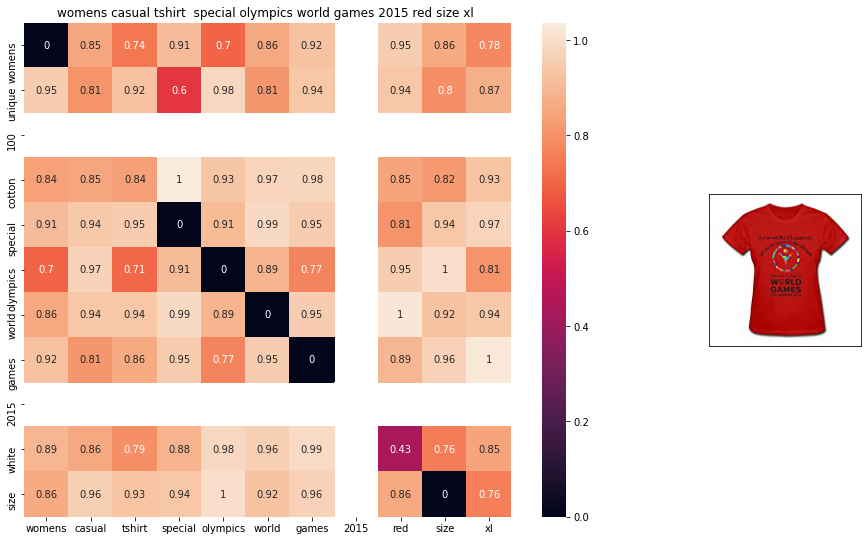

ASIN : B012YX3XTU
Title : womens casual tshirt  special olympics world games 2015 red size xl 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.1666666666666664


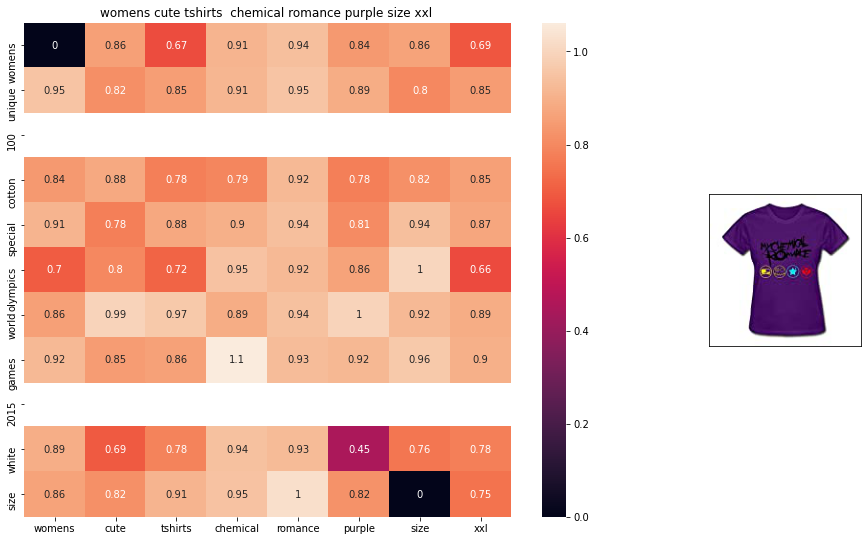

ASIN : B014A4FMOK
Title : womens cute tshirts  chemical romance purple size xxl 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.1666666666666664


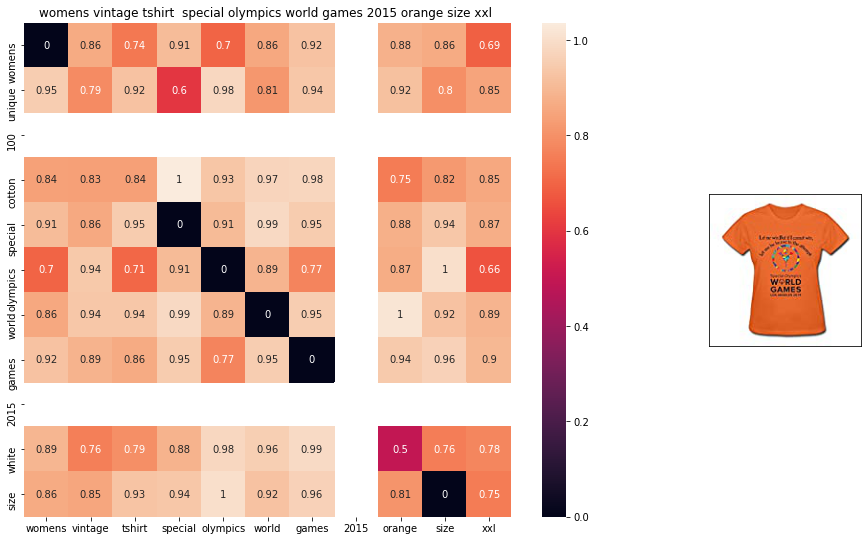

ASIN : B012YX4LVE
Title : womens vintage tshirt  special olympics world games 2015 orange size xxl 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.1666666666666664


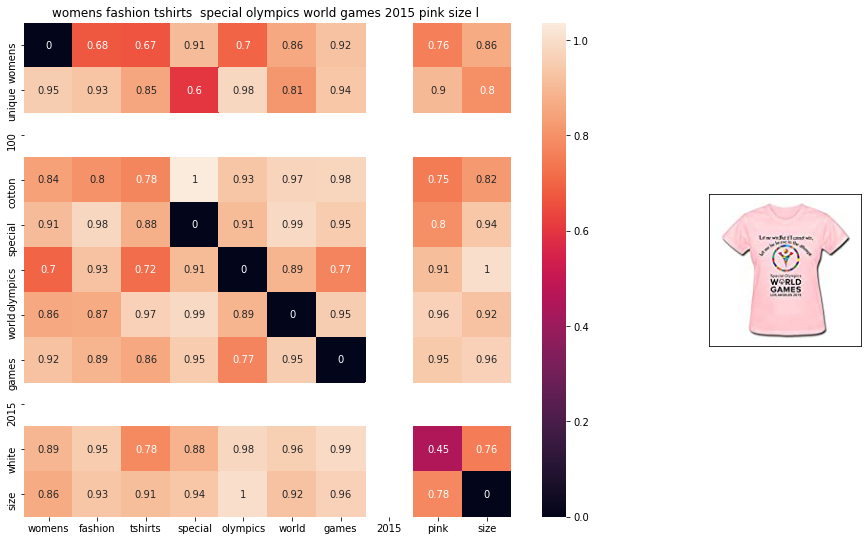

ASIN : B012YX26Q6
Title : womens fashion tshirts  special olympics world games 2015 pink size l 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.1666666666666664


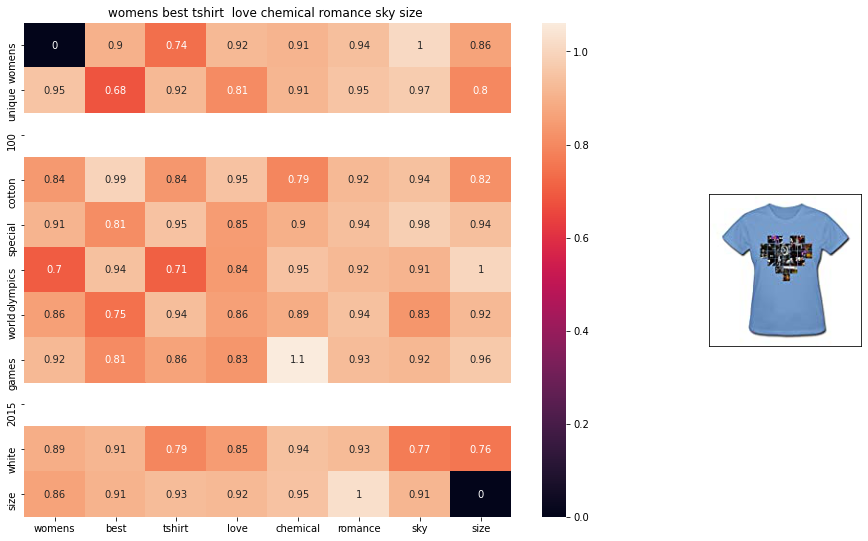

ASIN : B012NH07SC
Title : womens best tshirt  love chemical romance sky size 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.1666666666666664


In [ ]:
# brand and color weight =50
# title vector weight = 5

idf_w2v_brand(1, 0, 50, 10)

16319
[    1    89    28   169   105    72    48   150   236 11286]


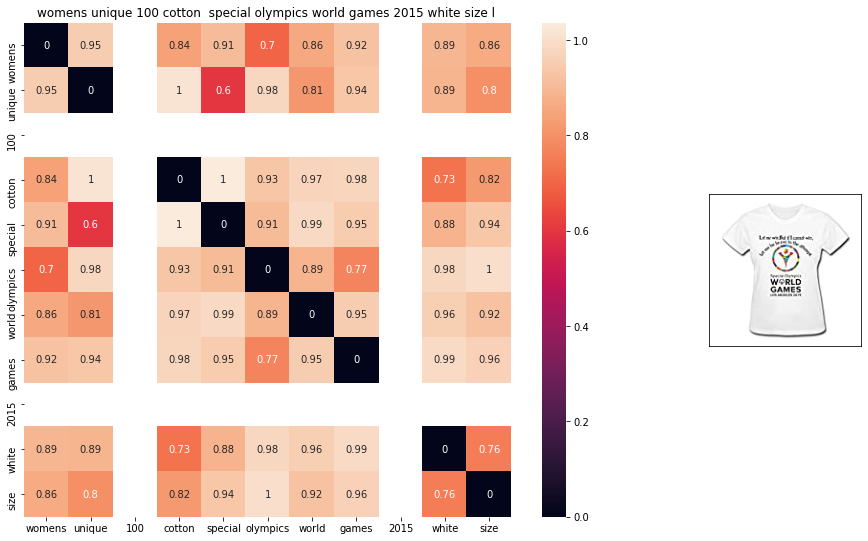

ASIN : B012YX2ZPI
Title : womens unique 100 cotton  special olympics world games 2015 white size l 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.0


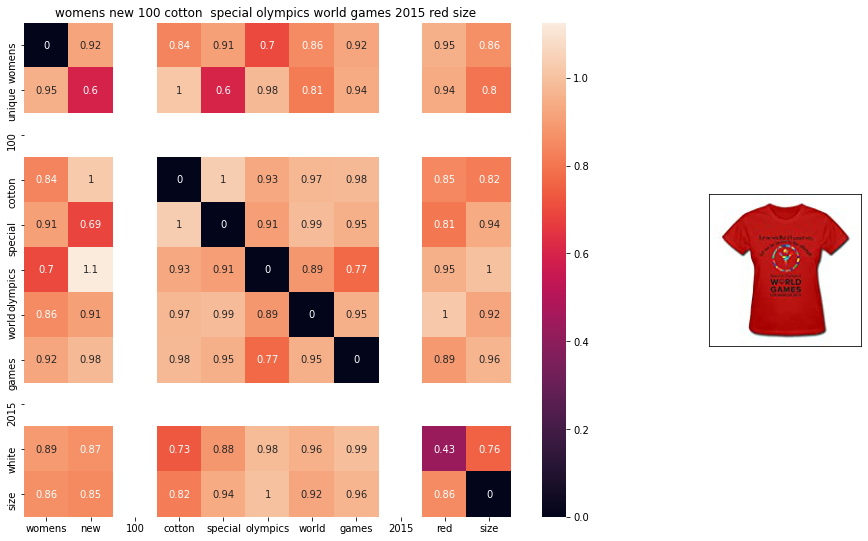

ASIN : B012YX3I5E
Title : womens new 100 cotton  special olympics world games 2015 red size 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.039391160011291504


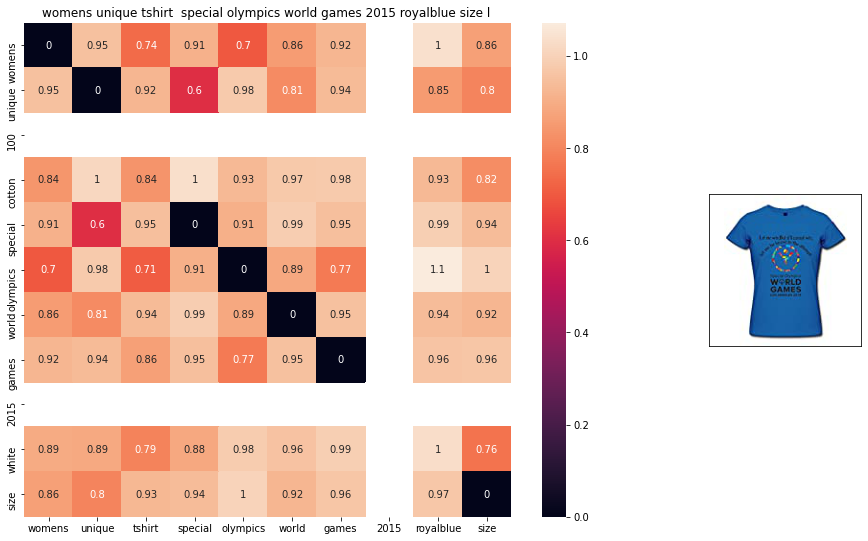

ASIN : B012YX4TVG
Title : womens unique tshirt  special olympics world games 2015 royalblue size l 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.04484272003173828


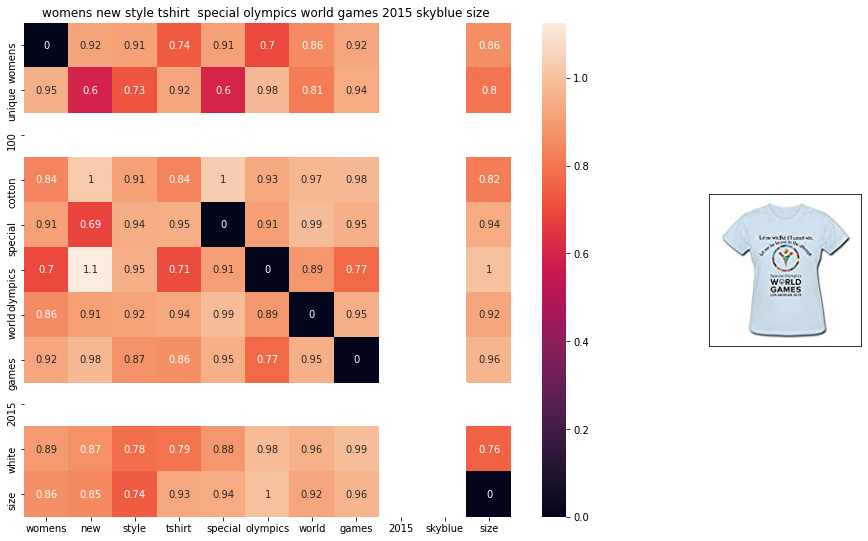

ASIN : B012YX2OJU
Title : womens new style tshirt  special olympics world games 2015 skyblue size 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.06632494926452637


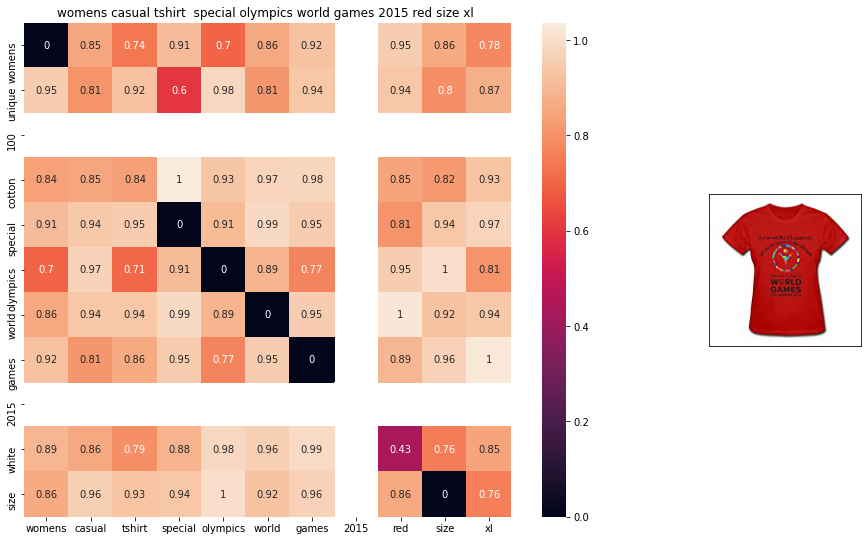

ASIN : B012YX3XTU
Title : womens casual tshirt  special olympics world games 2015 red size xl 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.07834148406982422


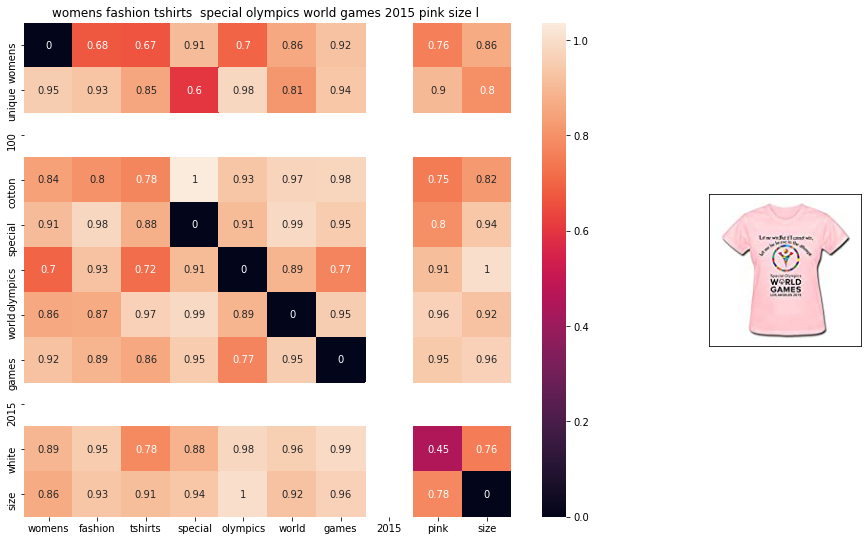

ASIN : B012YX26Q6
Title : womens fashion tshirts  special olympics world games 2015 pink size l 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.08702051639556885


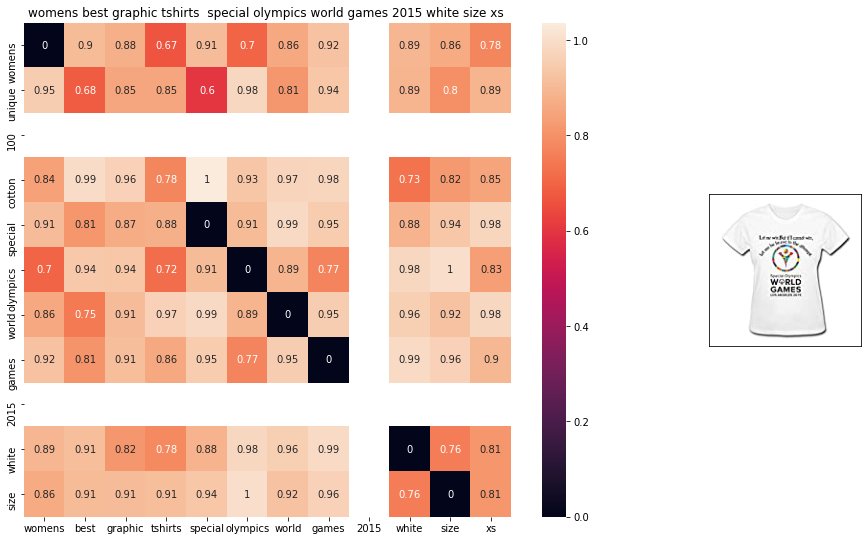

ASIN : B012YX2M3I
Title : womens best graphic tshirts  special olympics world games 2015 white size xs 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.08934080600738525


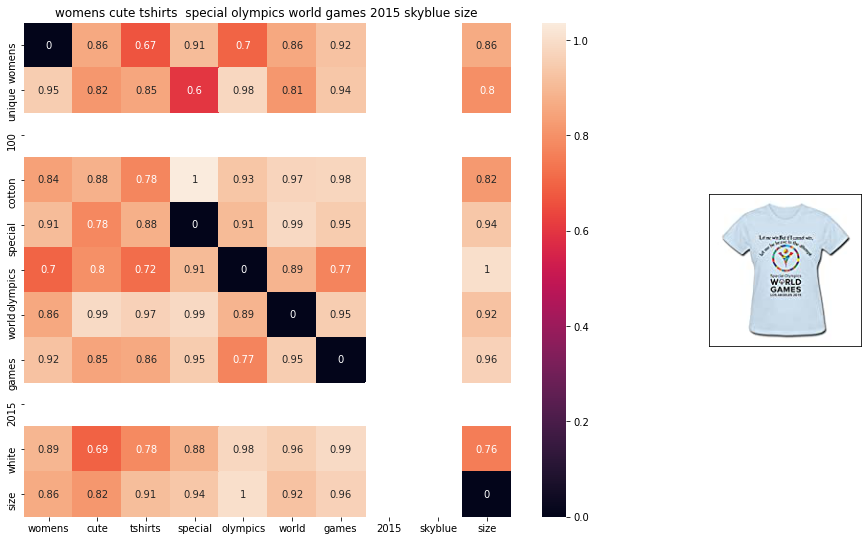

ASIN : B012YX30T8
Title : womens cute tshirts  special olympics world games 2015 skyblue size 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.08960771560668945


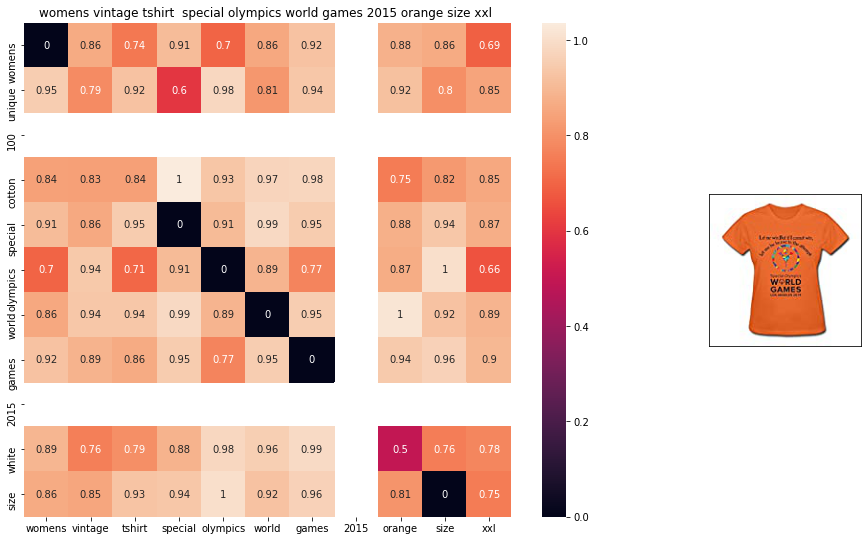

ASIN : B012YX4LVE
Title : womens vintage tshirt  special olympics world games 2015 orange size xxl 
Brand : HX-Kingdom Fashion T-shirts
cosine distance from input : 0.09147989749908447


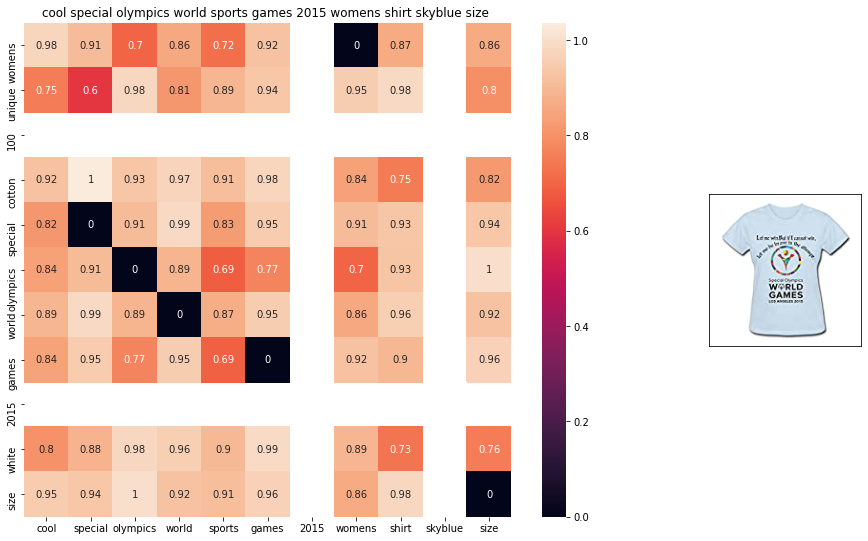

ASIN : B01338LWAM
Title : cool special olympics world sports games 2015 womens shirt skyblue size 
Brand : MAM2 Arts
cosine distance from input : 0.09727668762207031


In [ ]:

idf_w2v_brand(1, 1, 0, 10)

[nan nan nan ... nan nan nan]
[    0 10871 10872 ...  5447  5434 16318]


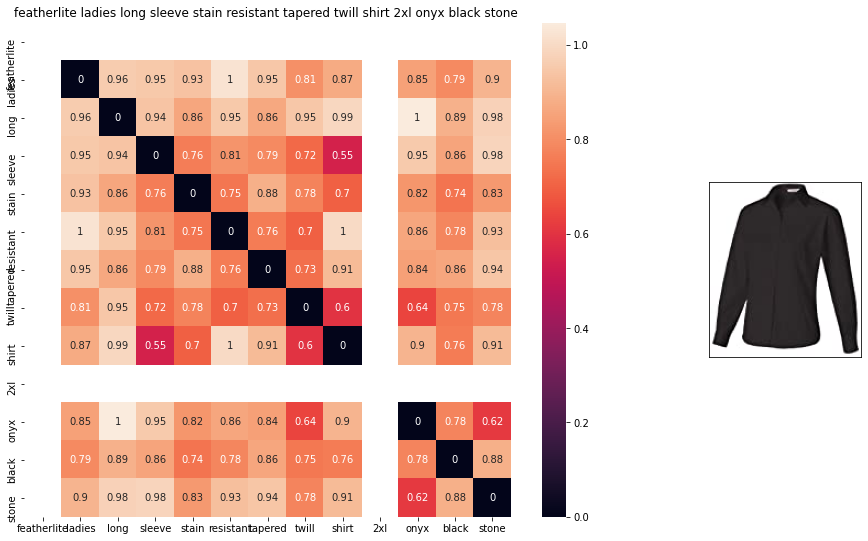

ASIN : B004GSI2OS
Title : featherlite ladies long sleeve stain resistant tapered twill shirt 2xl onyx black stone 
Brand : FeatherLite
cosine distance from input : nan


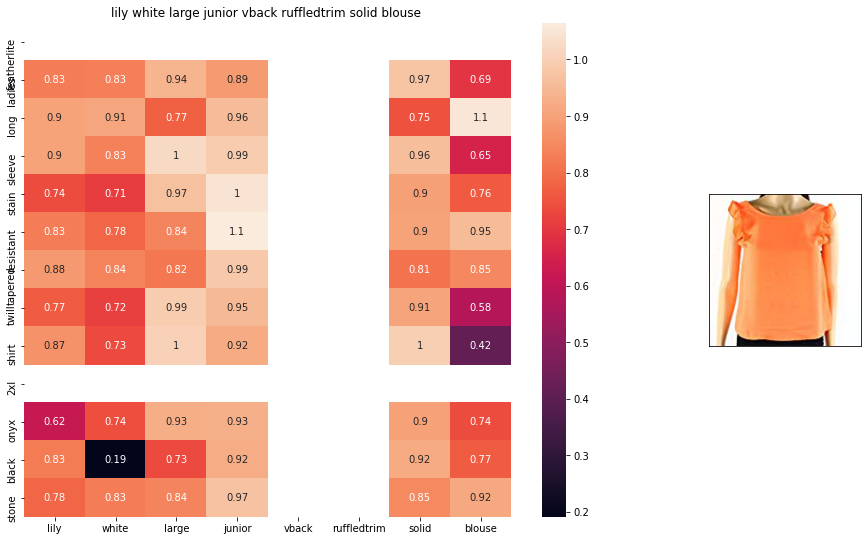

ASIN : B072XLH5QH
Title : lily white large junior vback ruffledtrim solid blouse 
Brand : Lily White
cosine distance from input : nan


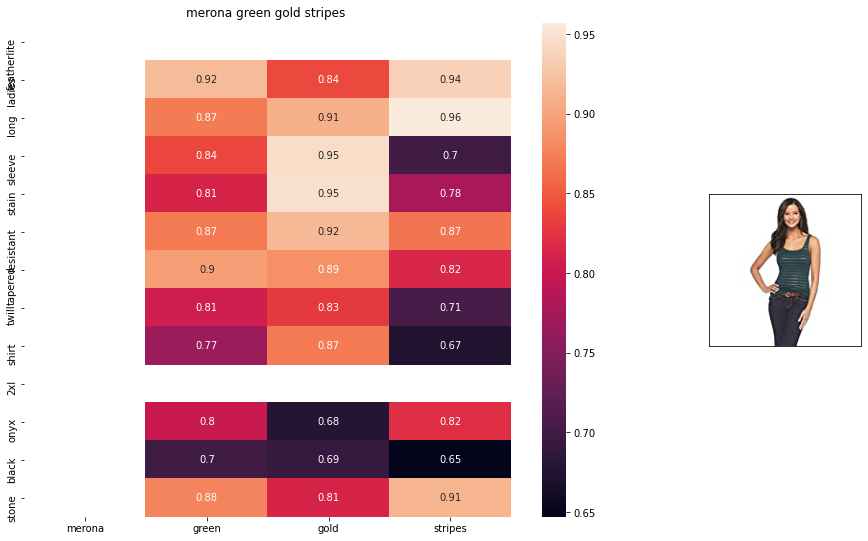

ASIN : B01KVZUB6G
Title : merona green gold stripes 
Brand : Merona
cosine distance from input : nan


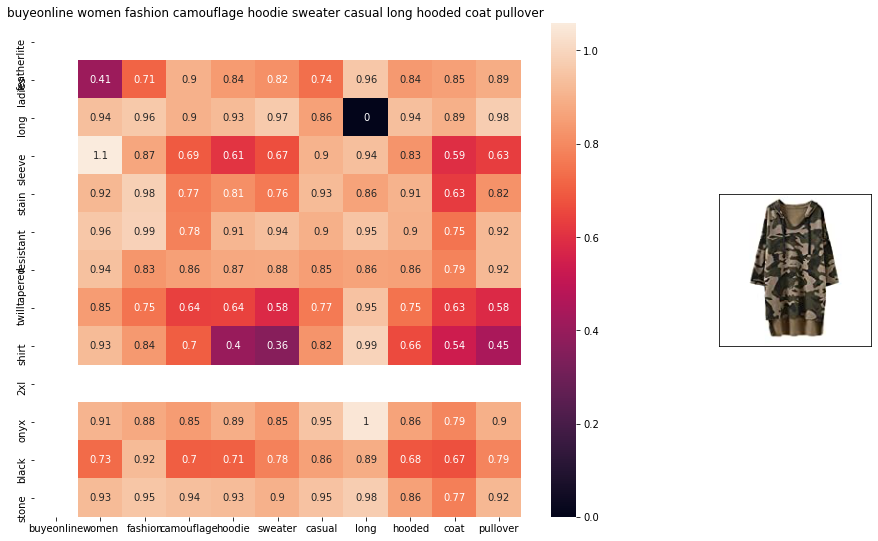

ASIN : B06XRZQH7V
Title : buyeonline women fashion camouflage hoodie sweater casual long hooded coat pullover 
Brand : BUYEONLINE
cosine distance from input : nan


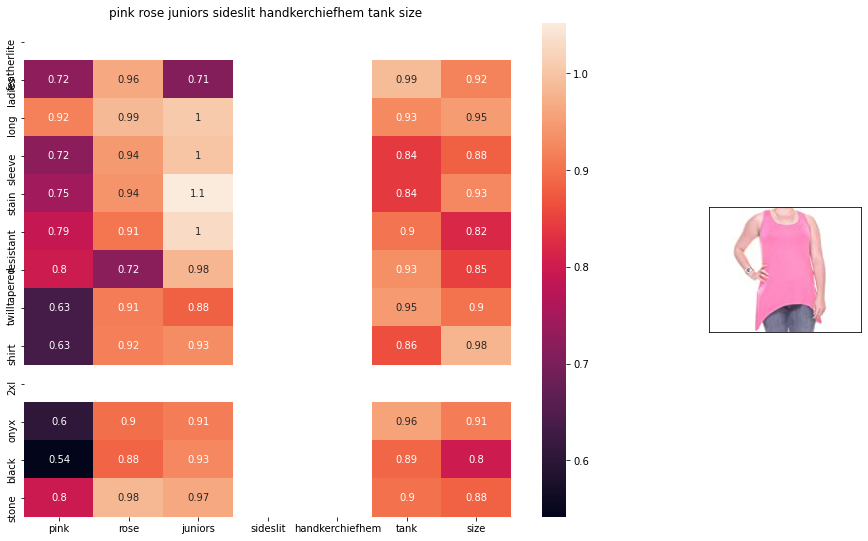

ASIN : B06WWBS47W
Title : pink rose juniors sideslit handkerchiefhem tank size 
Brand : PINK ROSE
cosine distance from input : nan


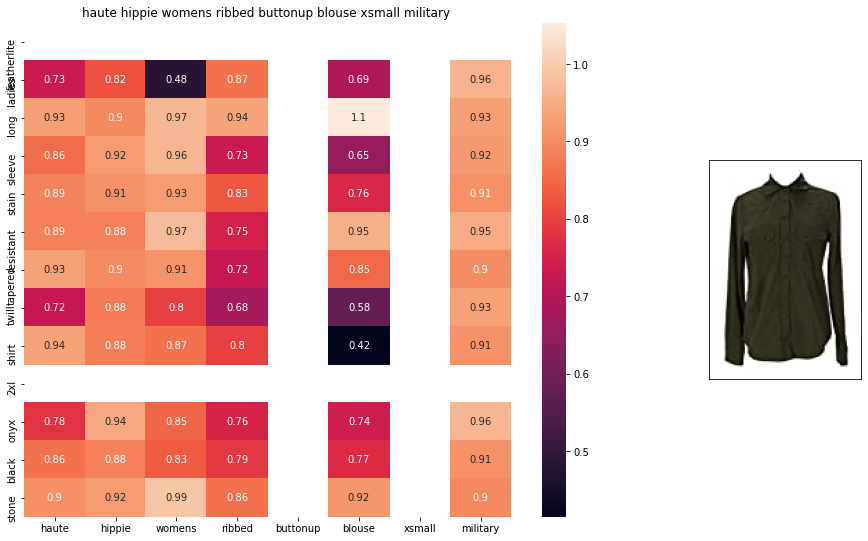

ASIN : B016080GXQ
Title : haute hippie womens ribbed buttonup blouse xsmall military 
Brand : Haute Hippie
cosine distance from input : nan


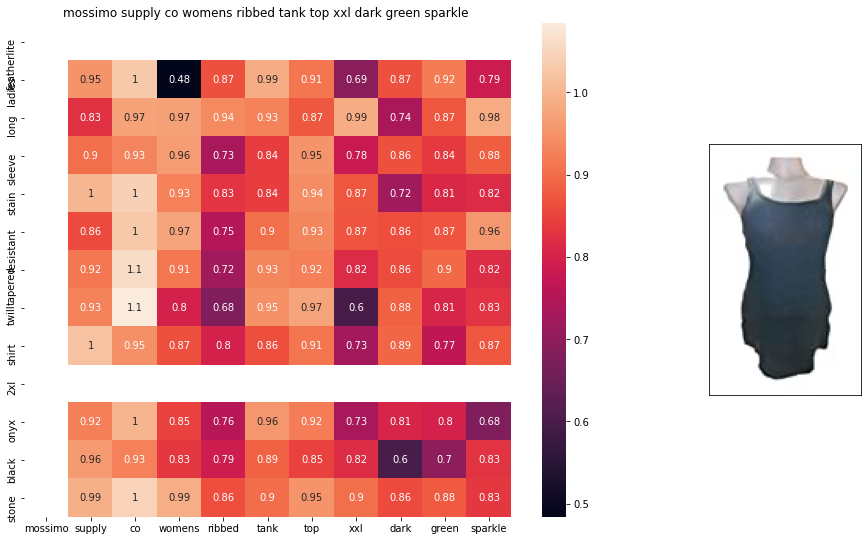

ASIN : B071NS5FGG
Title : mossimo supply co womens ribbed tank top xxl dark green sparkle 
Brand : Mossimo Supply Co
cosine distance from input : nan


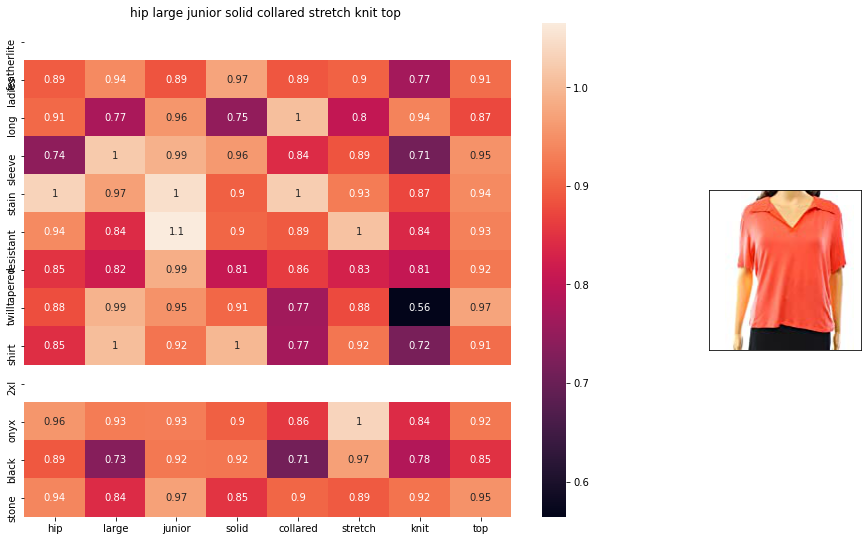

ASIN : B0758NZXPF
Title : hip large junior solid collared stretch knit top 
Brand : Hip
cosine distance from input : nan


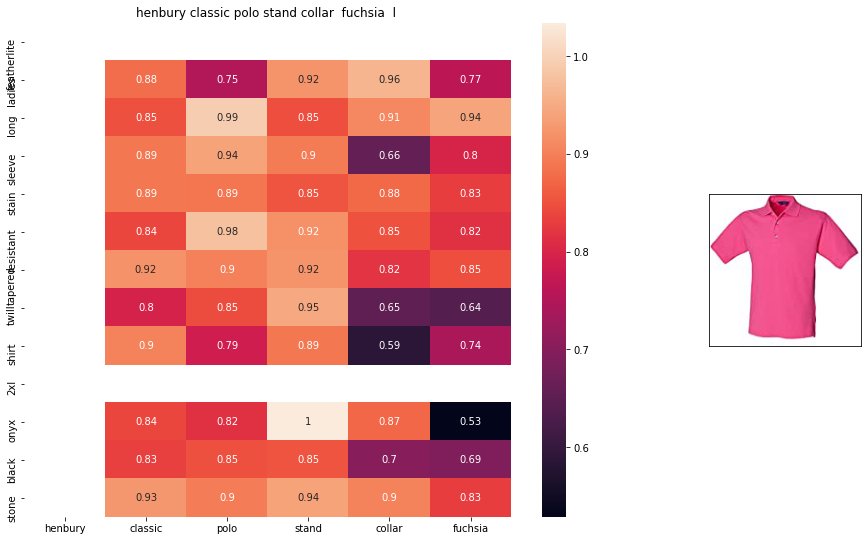

ASIN : B004X1C5IM
Title : henbury classic polo stand collar  fuchsia  l 
Brand : Henbury
cosine distance from input : nan


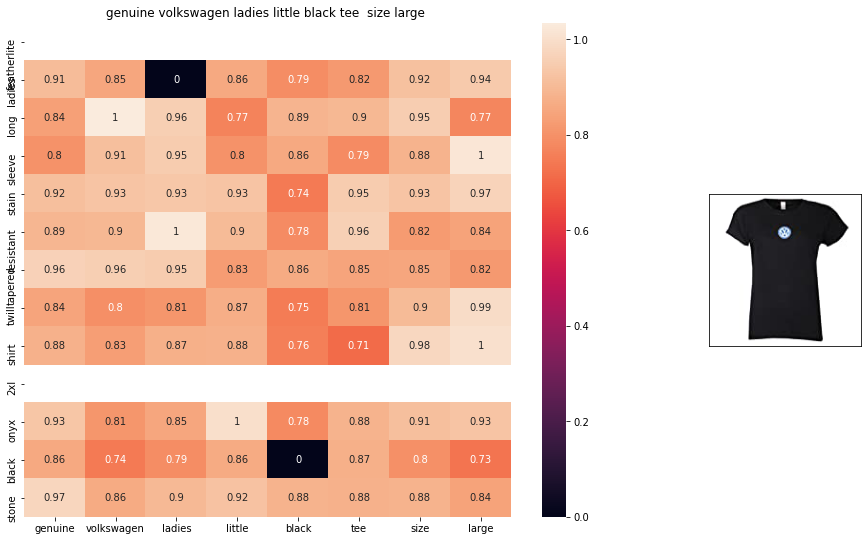

ASIN : B007UAEXPG
Title : genuine volkswagen ladies little black tee  size large 
Brand : VW
cosine distance from input : nan


In [ ]:


idf_w2v_brand(1, 0, 0, 10)

In [ ]:
a = np.full([1, 2,25], np.nan)
a

array([[[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan],
        [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
         nan]]])

In [ ]:
x = np.argsort(a.flatten(),kind='qicksort')
x

array([ 0, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42,
       43, 44, 45, 46, 47, 26, 25, 24, 23,  1,  2,  3,  4,  5,  6,  7,  8,
        9, 10, 48, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 12, 49])

# 5 Predict Rating on item profiles

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
rating_data = pd.read_csv('data/Clothing-Reviews.csv')
rating_data = rating_data.merge(data[['asin','product_type_name']],left_on='asin',right_on='asin')

In [ ]:
rating_data.head()

asin  ... product_type_name
0  B004GSI2OS  ...             SHIRT
1  B004GSI2OS  ...             SHIRT
2  B004GSI2OS  ...             SHIRT
3  B004GSI2OS  ...             SHIRT
4  B004GSI2OS  ...             SHIRT

[5 rows x 7 columns]

In [ ]:
rating_data.shape

(50046, 7)

In [ ]:
rating_data = rating_data[rating_data.groupby('review_userId')['review_userId'].transform('count').ge(5)]

In [ ]:
n_users = rating_data['review_userId'].nunique()
n_users

885

In [ ]:
n_items = rating_data['asin'].nunique()
n_items

5907

In [ ]:

users = rating_data.review_userId.unique()
items = rating_data.asin.unique()

In [ ]:
user2id = {o:i for i,o in enumerate(users)}
item2id = {o:i for i,o in enumerate(items)}

id2user = {v:k for k,v in user2id.items()}
id2item = {v:k for k,v in item2id.items()}

In [ ]:
len(id2user)

885

In [ ]:
rating_data['user_id'] = rating_data.review_userId.apply(lambda x: user2id[x])
rating_data['item_id'] = rating_data.asin.apply(lambda x: item2id[x])

In [ ]:
rating_data = rating_data.sort_values(by=['user_id', 'item_id']).reset_index(drop=True)
rating_data = rating_data[['user_id',	'item_id','review_score' ,'product_type_name']]

In [ ]:
rating_data.head()

user_id  item_id  review_score product_type_name
0        0        0             5             SHIRT
1        0       78             4             SHIRT
2        0      277             5             SHIRT
3        0      391             5             SHIRT
4        0      519             5             SHIRT

In [ ]:
rating_data.shape

(44178, 4)

In [ ]:
n_users = rating_data['user_id'].nunique()
n_users

885

In [ ]:
n_items = rating_data['item_id'].nunique()
n_items

5907

In [ ]:
rate_test = rating_data[['user_id','item_id','review_score']].drop_duplicates(keep='last', subset=['user_id']).reset_index(drop=True)
rate_train = rating_data[['user_id','item_id','review_score']][rating_data[['user_id','item_id','review_score']].duplicated(keep='last', subset=['user_id'])].reset_index(drop=True)


In [ ]:
rate_train = rate_train.values
rate_test = rate_test.values
print('Number of traing rates: ', rate_train.shape[0])
print('Number of test rates:', rate_test.shape[0])

Number of traing rates:  43293
Number of test rates: 885


In [ ]:
rate_train[:,1]

array([   0,   78,  277, ..., 1332, 1333, 1334])


Xây dựng item profiles
<br>

Công việc quan trọng trong content-based recommendation system là xây dựng profile cho mỗi item, tức feature vector cho mỗi item. Trước hết, chúng ta cần load toàn bộ thông tin về các items vào biến items

In [ ]:
df_item = rating_data[['item_id','product_type_name']].sort_values(by='item_id').drop_duplicates(subset=['item_id']).reset_index(drop=True)

df_item.head()

item_id product_type_name
0        0             SHIRT
1        1             SHIRT
2        2             SHIRT
3        3             SHIRT
4        4             SHIRT

In [ ]:
df_item['product_type_name'].unique()

array(['SHIRT', 'APPAREL', 'SPORTING_GOODS', 'BOOKS_1973_AND_LATER',
       'SWEATER', 'ACCESSORY', 'UNDERWEAR', 'OUTERWEAR',
       'OUTDOOR_RECREATION_PRODUCT', 'DRESS', 'SLEEPWEAR',
       'HEALTH_PERSONAL_CARE', 'MISC_OTHER', 'BLAZER', 'SKIRT', 'PANTS',
       'AUTO_ACCESSORY'], dtype=object)

In [ ]:
# one-hot encoding for category
df_genre = pd.get_dummies(df_item['product_type_name'])

Coi tất cả các type là có đơn vị trọng lượng. Đối với biểu diễn nhị phân, chúng ta có thể thực hiện chuẩn hóa bằng cách chia cụm từ xuất hiện cho sqrt số thuộc tính trong item.

In [ ]:
#normalized
df_genre_normalized = df_genre.apply(lambda x: x/np.sqrt(df_genre.sum(axis=1)))

In [ ]:
#create item profile
df_item = pd.concat([df_item, df_genre_normalized], axis=1)

df_item.drop(columns='product_type_name', inplace=True)

In [ ]:
df_item.sort_values('item_id', inplace=True)

In [ ]:
df_item.set_index('item_id', inplace=True)

In [ ]:
df_item.head()

ACCESSORY  APPAREL  AUTO_ACCESSORY  ...  SPORTING_GOODS  SWEATER  UNDERWEAR
item_id                                      ...                                    
0              0.0      0.0             0.0  ...             0.0      0.0        0.0
1              0.0      0.0             0.0  ...             0.0      0.0        0.0
2              0.0      0.0             0.0  ...             0.0      0.0        0.0
3              0.0      0.0             0.0  ...             0.0      0.0        0.0
4              0.0      0.0             0.0  ...             0.0      0.0        0.0

[5 rows x 17 columns]

In [ ]:
df_item.shape

(5907, 17)

In [ ]:
X0 = df_item.values
X_train_counts = X0[:, -17:]
# print X0
X_train_counts

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.]])

In [ ]:
#tfidf
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=True, norm ='l2')
tfidf = transformer.fit_transform(X_train_counts.tolist()).toarray()

In [ ]:
def get_items_rated_by_user(rate_matrix, user_id):
    """
    return (item_ids, scores)
    """
    y = rate_matrix[:,0] # all users
    # item indices rated by user_id
   
    ids = np.where(y == user_id)[0]
    
    item_ids = rate_matrix[ids, 1] # index starts from 0 
    scores = rate_matrix[ids, 2]
    return (item_ids, scores)

In [ ]:
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn import linear_model

d = tfidf.shape[1] # data dimension
W = np.zeros((d, n_users))
b = np.zeros((1, n_users))

for n in range(n_users):    
    item_ids, scores = get_items_rated_by_user(rate_train, n)
    
    clf = Ridge(alpha=0.01, fit_intercept  = True)
    Xhat = tfidf[item_ids, :]

    clf.fit(Xhat, scores) 
    W[:, n] = clf.coef_
    b[0, n] = clf.intercept_

In [ ]:
# predicted scores
Yhat = tfidf.dot(W) + b

Dưới đây là một ví dụ với user có id là 100.

In [ ]:
n = 100
ids, scores = get_items_rated_by_user(rate_test, n)
print(ids)
# Yhat[n, ids]
print('Rated item ids:', ids) 
print('True ratings:', scores)
print('Predicted ratings:', Yhat[ids, n])

[5808]
Rated item ids: [5808]
True ratings: [2]
Predicted ratings: [4.75]



Để đánh giá mô hình tìm được, chúng ta sẽ sử dụng Root Mean Squared Error (RMSE), tức căn bậc hai của trung bình cộng bình phương của lỗi. Lỗi được tính là hiệu của true rating và predicted rating:

In [ ]:
def rmse(Yhat, rates, W, b):
    se = 0
    cnt = 0
    for n in range(n_users):
        ids, scores_truth = get_items_rated_by_user(rates, n)
        scores_pred = Yhat[ids, n]
        e = scores_truth - scores_pred 
        se += (e*e).sum(axis = 0)
        cnt += e.size
    return math.sqrt(se/cnt)

print('RMSE for training:', rmse(Yhat, rate_train, W, b))
print('RMSE for test    :', rmse(Yhat, rate_test, W, b))

RMSE for training: 1.214596875685452
RMSE for test    : 1.5085216590109978


In [ ]:
def mae(Yhat, rates, W, b):
    se = 0
    cnt = 0
    for n in range(n_users):
        ids, scores_truth = get_items_rated_by_user(rates, n)
        scores_pred = Yhat[ids, n]
        e = scores_truth - scores_pred 
        e = np.absolute(e)
        se += e.sum(axis = 0)
        cnt += e.size
        
    return math.sqrt(se/cnt)

print('MAE for training:', mae(Yhat, rate_train, W, b))
print('MAE for test    :', mae(Yhat, rate_test, W, b))

MAE for training: 0.9651481260460208
MAE for test    : 1.094364413830241


In [ ]:
from sklearn import linear_model
d = tfidf.shape[1] # data dimension
W = np.zeros((d, n_users))
b = np.zeros((1, n_users))

for n in range(n_users):    
    item_ids, scores = get_items_rated_by_user(rate_train, n)
    
    clf = linear_model.LinearRegression()
    Xhat = tfidf[item_ids, :]

    clf.fit(Xhat, scores) 
    
    W[:, n] = clf.coef_
    b[0, n] = clf.intercept_

# predicted scores
Yhat = tfidf.dot(W) + b

In [ ]:
print('RMSE for training:', rmse(Yhat, rate_train, W, b))
print('RMSE for test    :', rmse(Yhat, rate_test, W, b))
print('MAE for training:', mae(Yhat, rate_train, W, b))
print('MAE for test    :', mae(Yhat, rate_test, W, b))

RMSE for training: 1.2439072645883444
RMSE for test    : 1.5083734977170262
MAE for training: 0.9675422310524661
MAE for test    : 1.0943314980508372
